In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 206s 23ms/step - loss: 0.6799 - acc: 0.8042 - val_loss: 6.8934 - val_acc: 0.3770
Epoch 2/100
9112/9112 [==============================] - 176s 19ms/step - loss: 0.3191 - acc: 0.9057 - val_loss: 1.1750 - val_acc: 0.7881
Epoch 3/100
9112/9112 [==============================] - 172s 19ms/step - loss: 0.2247 - acc: 0.9325 - val_loss: 3.3108 - val_acc: 0.4971
Epoch 4/100
9112/9112 [==============================] - 166s 18ms/step - loss: 0.1730 - acc: 0.9462 - val_loss: 1.7031 - val_acc: 0.7080
Epoch 5/100
9112/9112 [==============================] - 175s 19ms/step - loss: 0.1385 - acc: 0.9581 - val_loss: 0.9165 - val_acc: 0.8330
Epoch 6/100
9112/9112 [==============================] - 175s 19ms/step - loss: 0.1228 - acc: 0.9613 - val_loss: 0.4560 - val_acc: 0.8945
Epoch 7/100
9112/9112 [==============================] - 173s 19ms/step - loss: 0.1269 - acc: 0.9622 - val_loss: 0.4035 - va

9114/9114 [==============================] - 122s 13ms/step - loss: 0.0615 - acc: 0.9806 - val_loss: 1.1142 - val_acc: 0.8023
Epoch 17/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0687 - acc: 0.9784 - val_loss: 6.6076 - val_acc: 0.4256
Epoch 18/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0668 - acc: 0.9781 - val_loss: 0.4038 - val_acc: 0.9080
Epoch 19/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0499 - acc: 0.9839 - val_loss: 0.3838 - val_acc: 0.8992
Epoch 20/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0369 - acc: 0.9892 - val_loss: 0.5018 - val_acc: 0.8219
Epoch 21/100
9114/9114 [==============================] - 121s 13ms/step - loss: 0.0387 - acc: 0.9873 - val_loss: 0.2560 - val_acc: 0.9472
Epoch 22/100
9114/9114 [==============================] - 123s 13ms/step - loss: 0.0501 - acc: 0.9824 - val_loss: 1.5677 - val_acc: 0.7886
Epoch 23/100
9114/9114 [================

9114/9114 [==============================] - 122s 13ms/step - loss: 0.0028 - acc: 0.9997 - val_loss: 0.2313 - val_acc: 0.9628
Epoch 76/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.2072 - val_acc: 0.9618
Epoch 77/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.2297 - val_acc: 0.9648
Epoch 78/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0217 - acc: 0.9940 - val_loss: 4.6716 - val_acc: 0.5460
Epoch 79/100
9114/9114 [==============================] - 123s 13ms/step - loss: 0.0382 - acc: 0.9884 - val_loss: 0.3494 - val_acc: 0.9511
Epoch 80/100
9114/9114 [==============================] - 121s 13ms/step - loss: 0.0087 - acc: 0.9977 - val_loss: 0.2157 - val_acc: 0.9599
Epoch 81/100
9114/9114 [==============================] - 122s 13ms/step - loss: 0.0080 - acc: 0.9984 - val_loss: 0.2034 - val_acc: 0.9589
Epoch 82/100
9114/9114 [================

9116/9116 [==============================] - 122s 13ms/step - loss: 0.0186 - acc: 0.9939 - val_loss: 1.2175 - val_acc: 0.7922
Epoch 34/100
9116/9116 [==============================] - 121s 13ms/step - loss: 0.0277 - acc: 0.9911 - val_loss: 0.2979 - val_acc: 0.9431
Epoch 35/100
9116/9116 [==============================] - 122s 13ms/step - loss: 0.0215 - acc: 0.9933 - val_loss: 7.1418 - val_acc: 0.4167
Epoch 36/100
9116/9116 [==============================] - 122s 13ms/step - loss: 0.0286 - acc: 0.9906 - val_loss: 0.2887 - val_acc: 0.9520
Epoch 37/100
9116/9116 [==============================] - 123s 13ms/step - loss: 0.0163 - acc: 0.9944 - val_loss: 0.2571 - val_acc: 0.9578
Epoch 38/100
9116/9116 [==============================] - 123s 13ms/step - loss: 0.0114 - acc: 0.9962 - val_loss: 0.3076 - val_acc: 0.9510
Epoch 39/100
9116/9116 [==============================] - 124s 14ms/step - loss: 0.0087 - acc: 0.9970 - val_loss: 0.2549 - val_acc: 0.9588
Epoch 40/100
9116/9116 [================

Epoch 67/100
9125/9125 [==============================] - 126s 14ms/step - loss: 0.0349 - acc: 0.9907 - val_loss: 1.9131 - val_acc: 0.7864
Epoch 68/100
9125/9125 [==============================] - 128s 14ms/step - loss: 0.0339 - acc: 0.9893 - val_loss: 0.2018 - val_acc: 0.9683
Epoch 69/100
9125/9125 [==============================] - 125s 14ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 5.3622 - val_acc: 0.6271
Epoch 70/100
9125/9125 [==============================] - 125s 14ms/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.2211 - val_acc: 0.9674
Epoch 71/100
9125/9125 [==============================] - 125s 14ms/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.3639 - val_acc: 0.9357
Epoch 72/100
9125/9125 [==============================] - 125s 14ms/step - loss: 0.0372 - acc: 0.9904 - val_loss: 4.3609 - val_acc: 0.5262
Epoch 73/100
9125/9125 [==============================] - 125s 14ms/step - loss: 0.0091 - acc: 0.9977 - val_loss: 0.3573 - val_acc: 0.9446
Epoch 74/100
9125/9125 [===

Epoch 25/100
9127/9127 [==============================] - 180s 20ms/step - loss: 0.0285 - acc: 0.9901 - val_loss: 0.2461 - val_acc: 0.9504
Epoch 26/100
9127/9127 [==============================] - 178s 20ms/step - loss: 0.0220 - acc: 0.9931 - val_loss: 0.2530 - val_acc: 0.9356
Epoch 27/100
9127/9127 [==============================] - 174s 19ms/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.5469 - val_acc: 0.8949
Epoch 28/100
9127/9127 [==============================] - 184s 20ms/step - loss: 0.0322 - acc: 0.9905 - val_loss: 2.6658 - val_acc: 0.6224
Epoch 29/100
9127/9127 [==============================] - 179s 20ms/step - loss: 0.0472 - acc: 0.9838 - val_loss: 0.4595 - val_acc: 0.9098
Epoch 30/100
9127/9127 [==============================] - 181s 20ms/step - loss: 0.0191 - acc: 0.9939 - val_loss: 0.5130 - val_acc: 0.8949
Epoch 31/100
9127/9127 [==============================] - 176s 19ms/step - loss: 0.0264 - acc: 0.9913 - val_loss: 0.6528 - val_acc: 0.8821
Epoch 32/100
9127/9127 [===

Epoch 84/100
9127/9127 [==============================] - 251s 28ms/step - loss: 0.0043 - acc: 0.9989 - val_loss: 0.2363 - val_acc: 0.9475
Epoch 85/100
9127/9127 [==============================] - 253s 28ms/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.2313 - val_acc: 0.9584
Epoch 86/100
9127/9127 [==============================] - 259s 28ms/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.6553 - val_acc: 0.8276
Epoch 87/100
9127/9127 [==============================] - 250s 27ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.2195 - val_acc: 0.9643
Epoch 88/100
9127/9127 [==============================] - 256s 28ms/step - loss: 0.0128 - acc: 0.9955 - val_loss: 0.2386 - val_acc: 0.9564
Epoch 89/100
9127/9127 [==============================] - 257s 28ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.2358 - val_acc: 0.9564
Epoch 90/100
9127/9127 [==============================] - 258s 28ms/step - loss: 0.0099 - acc: 0.9974 - val_loss: 0.2422 - val_acc: 0.9584
Epoch 91/100
9127/9127 [===

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9658


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

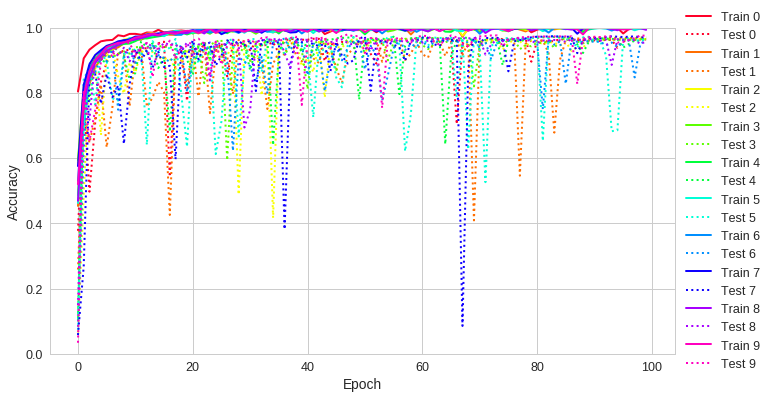

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

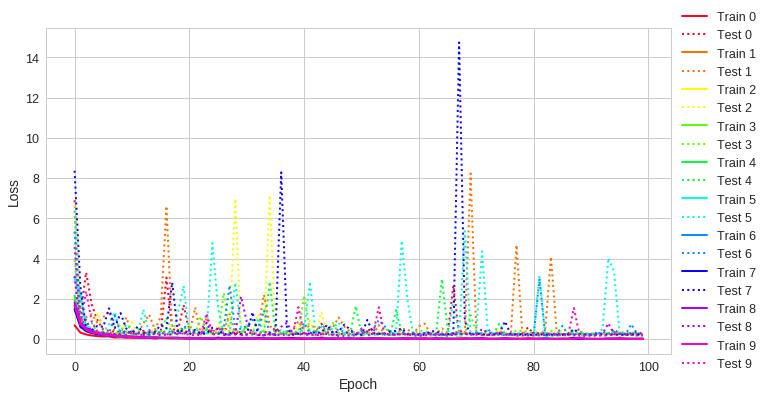

In [25]:
plot_loss(history)

Plotting the confusion matrix


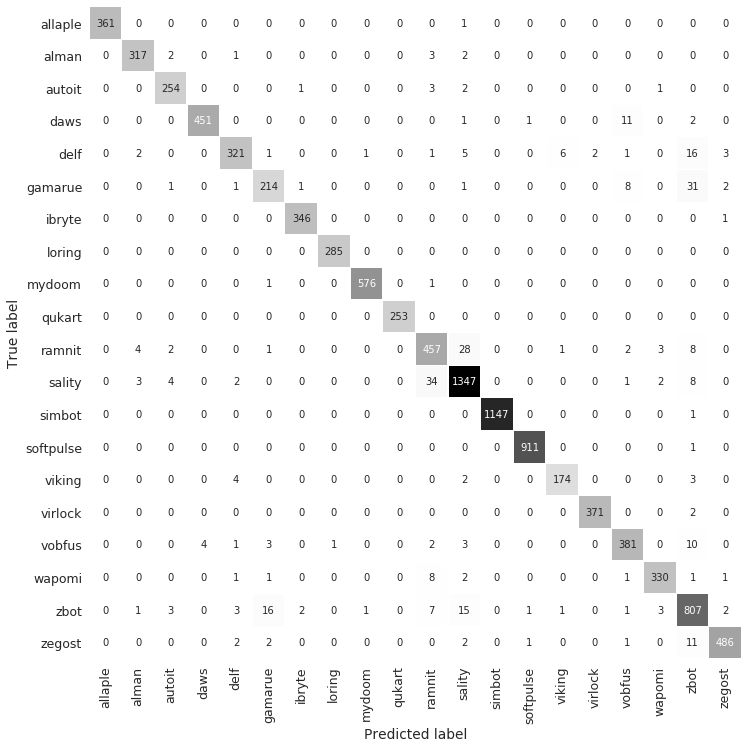

In [28]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


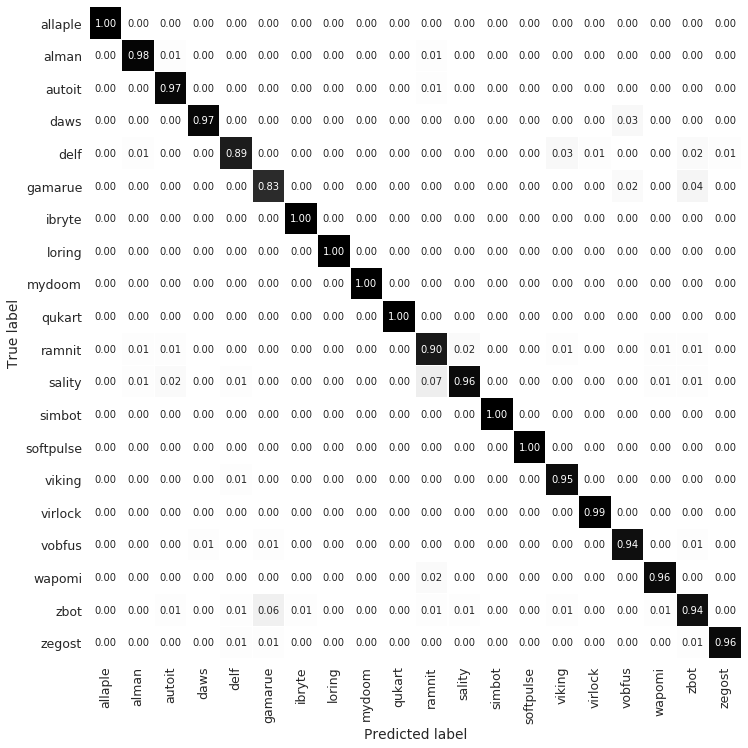

In [29]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
for h in history:
    print(h.history)

{'val_loss': [6.893376559601166, 1.1749571672172578, 3.3108071397291496, 1.7030985335059086, 0.9164828886688383, 0.45599280810917264, 0.40349849863332876, 0.35142060036437783, 0.36942551522605616, 0.2612155002424288, 0.39401253361029376, 0.31935227741792005, 0.40701683020674295, 0.3007294697221683, 0.2806069368838289, 0.2908080220638669, 3.0522517763310617, 0.5030759994006679, 0.39484448709060427, 1.6846444755694563, 0.3473209460950111, 0.43732054877955306, 0.28077625415241414, 0.40464265234701147, 0.4384848182772121, 0.28164063869024325, 0.5944331672036758, 0.282822499367267, 0.321127339007774, 0.3502920366187263, 0.3348224597552747, 0.2808180242606402, 0.29587272715829815, 0.37560257532928754, 0.2613023541965429, 0.5782603279067233, 0.25056599236329813, 0.2814683067038577, 0.240881078219922, 0.2642684959555823, 0.24271691320328914, 0.22834223194774728, 0.232453104315836, 0.7609489196254859, 0.3268395626194591, 0.3195537421264092, 0.2891988915097312, 0.25047403413921643, 0.23099582203

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

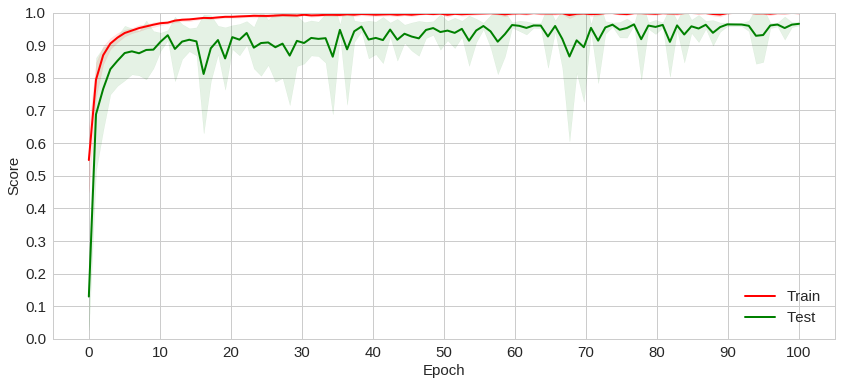

In [32]:
plot_mean_acc(history)

In [33]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

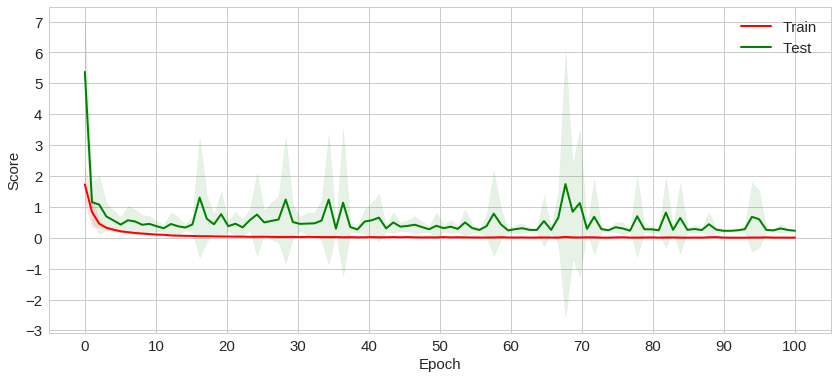

In [34]:
plot_mean_loss(history)

In [35]:
hist = [{'val_loss': [6.893376559601166, 1.1749571672172578, 3.3108071397291496, 1.7030985335059086, 0.9164828886688383, 0.45599280810917264, 0.40349849863332876, 0.35142060036437783, 0.36942551522605616, 0.2612155002424288, 0.39401253361029376, 0.31935227741792005, 0.40701683020674295, 0.3007294697221683, 0.2806069368838289, 0.2908080220638669, 3.0522517763310617, 0.5030759994006679, 0.39484448709060427, 1.6846444755694563, 0.3473209460950111, 0.43732054877955306, 0.28077625415241414, 0.40464265234701147, 0.4384848182772121, 0.28164063869024325, 0.5944331672036758, 0.282822499367267, 0.321127339007774, 0.3502920366187263, 0.3348224597552747, 0.2808180242606402, 0.29587272715829815, 0.37560257532928754, 0.2613023541965429, 0.5782603279067233, 0.25056599236329813, 0.2814683067038577, 0.240881078219922, 0.2642684959555823, 0.24271691320328914, 0.22834223194774728, 0.232453104315836, 0.7609489196254859, 0.3268395626194591, 0.3195537421264092, 0.2891988915097312, 0.25047403413921643, 0.2309958220322117, 0.26352003927664036, 0.25711051104485305, 0.4336684998932916, 0.47426884778890344, 0.2908126273969476, 0.2569964283815387, 0.23765220125558262, 0.23376293751440302, 0.23403652965960964, 0.2321199166947654, 0.2247053764730289, 0.22931283264211189, 0.22799892309910597, 0.22587197293750982, 0.23016667988300998, 0.22969514273452196, 0.23594225582605555, 2.6571192695157997, 0.23118386207681896, 0.2805389057193546, 0.2538781445688034, 0.27168380402138403, 0.24630771716310917, 0.21894691816989154, 0.22020099647408342, 0.21663250570607628, 0.21711623586865292, 0.21874642004703526, 0.22691642183558036, 0.22727225206845425, 0.5796129195214168, 0.24037827027040182, 0.2672601827111962, 0.3074066731059495, 0.2999305602114526, 0.22793512784186243, 0.2416142115020392, 0.24225091422249667, 0.2416821679293415, 0.28355822141336784, 0.2611376257147904, 0.26527018087115906, 0.26273452190733027, 0.2672869408944125, 0.2777923796197772, 0.4768305331469169, 0.2575619355849157, 0.22969753843941865, 0.2620847886234223, 0.24218393916467829, 0.23266980730266873], 'acc': [0.8042142230549646, 0.9057287093942055, 0.9325065847757723, 0.9462247586124711, 0.9580772607550483, 0.9612598771898238, 0.9622475856014048, 0.9766242318869265, 0.9736611062335382, 0.9807945566286216, 0.9809043020193152, 0.9782704127473304, 0.9851843722563652, 0.9843064091308165, 0.9934152765583846, 0.9851843723086959, 0.9875987708516243, 0.9900131694468832, 0.9912203688491741, 0.9894644425980766, 0.9826602282704127, 0.9941834942932397, 0.9929762949956101, 0.9970368745559344, 0.9891352063213346, 0.9933055311676909, 0.992756804214223, 0.9912203687445127, 0.9952809482001755, 0.9917690956979807, 0.9963784021071115, 0.9902326602282704, 0.9952809482001755, 0.9959394205443372, 0.9937445127304653, 0.9901229148375769, 0.9967076382791923, 0.9990122914837577, 0.9993415276558385, 0.9993415277604998, 0.9997805092186128, 0.9997805092186128, 0.9998902546093064, 0.9802458296751536, 0.9881474978050921, 0.9956101844769177, 0.9961589113257243, 0.997585601404741, 0.9980245829675154, 0.9992317822651449, 0.9996707638279192, 0.9969271290605795, 0.9858428446005267, 0.9965978928884986, 0.9995610184372257, 0.9997805092186128, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9990122915884191, 0.9726733977172959, 0.9976953467954346, 0.9978050921861282, 0.9978050922907895, 0.9980245829675154, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9857330992098332, 0.9937445127304653, 0.9979148375768218, 0.9979148375768218, 0.9984635645302897, 0.9996707638279192, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9995610184372257, 0.982001755926251, 0.9960491659350307, 0.9984635645302897, 0.9998902546093064, 0.9998902546093064], 'loss': [0.6798825125300748, 0.31913818785294407, 0.22472455578220843, 0.17297747912403783, 0.13849907842341277, 0.12283724666302459, 0.12694562061528714, 0.07197881818203626, 0.08222448304921055, 0.06090488088708878, 0.061971823509890486, 0.065950355027382, 0.04588633440937798, 0.054859936503000285, 0.021651164520505525, 0.05443039829405295, 0.03807001630790962, 0.03347168450567363, 0.02742841741284482, 0.03778080525682831, 0.06406337521660377, 0.01716508580177746, 0.022746900944794802, 0.012758268923789728, 0.036520782006839884, 0.01987336225302962, 0.024655388175573546, 0.028550955156142414, 0.01615224047902663, 0.026618642809233956, 0.011295322074722329, 0.03303030485824056, 0.014559771816664473, 0.014009395821576889, 0.01871345364272299, 0.0324705605445297, 0.009878083325774056, 0.002676300694028413, 0.0019458481576267357, 0.0019001111560129726, 0.0010836084646880736, 0.0008729117641983614, 0.0006358665708483664, 0.07253573816584852, 0.03232011278087604, 0.015280768106411118, 0.014636851313336722, 0.011215155320840222, 0.007180234915795856, 0.002385155030816023, 0.0014648024973900468, 0.009722157321547336, 0.04694171091047471, 0.013277200865833965, 0.0019689520391287367, 0.0007687461995517509, 0.0007486171523408456, 0.0007088568762121103, 0.0006056887277045973, 0.0006771631084038554, 0.0006363756486185758, 0.0005958538587260148, 0.0007939655755671314, 0.0005586411079179063, 0.0005566966018317914, 0.0006676643672190131, 0.0025701258384346927, 0.10506886123367638, 0.009858390192442707, 0.006365115324826788, 0.008671309037844199, 0.004218077905085543, 0.0009161556659311079, 0.000672565100859566, 0.0006357010758998054, 0.000546030699464149, 0.0005412345852089975, 0.0006293062959567922, 0.0006412866118755967, 0.05230954192322009, 0.02212269631395106, 0.008187958762866755, 0.0061009551533497295, 0.0037652370973601463, 0.0016295999022249489, 0.0006842997890466956, 0.0006552871983546384, 0.0005527554053946096, 0.000503538399831126, 0.0006783929656111587, 0.0005574674271461044, 0.0006951102875092499, 0.000558805738038815, 0.0006556210015724475, 0.0015439456399645227, 0.06963088212691318, 0.012670555719570004, 0.004396510427784695, 0.0008057651351718624, 0.0007521828586758777], 'val_acc': [0.376953125, 0.7880859375, 0.4970703125, 0.7080078125, 0.8330078125, 0.89453125, 0.923828125, 0.9189453125, 0.9306640625, 0.931640625, 0.9189453125, 0.93359375, 0.9375, 0.935546875, 0.9521484375, 0.95703125, 0.54296875, 0.9091796875, 0.931640625, 0.775390625, 0.9462890625, 0.916015625, 0.9541015625, 0.9287109375, 0.927734375, 0.953125, 0.8505859375, 0.9501953125, 0.953125, 0.9501953125, 0.9306640625, 0.955078125, 0.943359375, 0.9482421875, 0.955078125, 0.921875, 0.9599609375, 0.9658203125, 0.9638671875, 0.962890625, 0.962890625, 0.9658203125, 0.9658203125, 0.8974609375, 0.94921875, 0.94921875, 0.9560546875, 0.955078125, 0.95703125, 0.95703125, 0.9580078125, 0.919921875, 0.8896484375, 0.9580078125, 0.9619140625, 0.962890625, 0.962890625, 0.9638671875, 0.962890625, 0.96484375, 0.96484375, 0.966796875, 0.9658203125, 0.9658203125, 0.96484375, 0.96484375, 0.7041015625, 0.953125, 0.9404296875, 0.9560546875, 0.9560546875, 0.9609375, 0.96484375, 0.966796875, 0.96484375, 0.9658203125, 0.9638671875, 0.962890625, 0.966796875, 0.8955078125, 0.9599609375, 0.9599609375, 0.95703125, 0.958984375, 0.96484375, 0.962890625, 0.962890625, 0.9619140625, 0.9609375, 0.9609375, 0.9609375, 0.958984375, 0.962890625, 0.9619140625, 0.9384765625, 0.9580078125, 0.9619140625, 0.9619140625, 0.9638671875, 0.9638671875]},
{'val_loss': [3.1337367830444456, 0.8518897568817941, 1.0904155135019855, 1.2427746607118273, 0.7767880190967595, 1.0807353846214842, 1.3762605994754904, 0.24728128036444028, 0.24819362556120772, 1.075419973308647, 0.2992891787773595, 0.2457260255945168, 0.7873509669997192, 1.218675140975323, 0.453328976709279, 1.1141730408538133, 6.60755764553742, 0.40384325833258505, 0.3837681794261155, 0.5017976511794702, 0.25600114543493946, 1.56772256796238, 0.222601835646676, 1.0742660434614755, 0.35359858292797136, 0.2675220231216231, 0.41927056677126817, 1.2387401805865683, 0.20712528394033533, 0.227700568864851, 0.5134783585363875, 0.3408472405149068, 0.4893533793159744, 2.2020961809283714, 0.6561621167683483, 0.3516234622551362, 0.4170925715352887, 0.18077717112287972, 0.520019230319846, 0.8759658272008548, 0.4834331515133689, 0.6728553908390765, 0.5734979787405394, 0.2531549258661251, 0.36165585576410325, 0.564206101447282, 1.0740769696576926, 0.6212542938637582, 0.35564720458128873, 0.30370813621082465, 0.26519693740926054, 0.18320870929397437, 0.2106445033284209, 0.6876565012643976, 0.21806859502130874, 0.21756192208809183, 0.24709499634485171, 0.4899313673027015, 0.49004969445074203, 0.25818815881314205, 0.6269637137102972, 0.7624390414248975, 0.26320832878245926, 0.24917996914984486, 0.5347344345419082, 0.29293139086601677, 0.22282763365110295, 0.4478262667387494, 0.3199213701413783, 8.226039845463154, 0.3218089810684744, 0.27648741544366345, 0.221726217426821, 0.2176980577252328, 0.23132942724097533, 0.2071634333303591, 0.22968391280077602, 4.671588970899103, 0.34944065762062115, 0.21566783839379117, 0.20344629265544492, 0.19752056506170843, 0.43054242513527563, 4.084661477436761, 0.36418562259633713, 0.26253324815775025, 0.2069807333760562, 0.19336401539824336, 0.1939515400488183, 0.1911182090985207, 0.20220976059827298, 0.18851658701926102, 0.20106999005430562, 0.20355538502945403, 0.19886605173569136, 0.20537793319378092, 0.20185019351510625, 0.20816505202653804, 0.19097183636587092, 0.19853228281906582], 'acc': [0.45336844432189166, 0.7388632873027032, 0.8274083827340815, 0.8784287910543044, 0.9039938556983175, 0.9234145272058014, 0.9338380513495721, 0.9396532807586642, 0.9521615097651964, 0.9598420014082143, 0.9641211323238973, 0.963133640644554, 0.9713627387354032, 0.9735571648014044, 0.9749835418038183, 0.9805793285055958, 0.978384902348036, 0.978055738424402, 0.983870967833494, 0.989247311827957, 0.9872723284692704, 0.9824445907395216, 0.989027869212201, 0.989466754443713, 0.9854070660522274, 0.984858459604396, 0.9911125740618828, 0.9925389510642967, 0.9962694756237069, 0.989357033135835, 0.9912222953697608, 0.9934167215273206, 0.9928681149879307, 0.9900153609831029, 0.9856265086679833, 0.9905639675224929, 0.9956111476848803, 0.9952819837612464, 0.9967083607636603, 0.9952819837612464, 0.9922097871406628, 0.9930875576036866, 0.9941847706824666, 0.9930875576952453, 0.9919903445249068, 0.9969278033794163, 0.9960500329163924, 0.9944042132982225, 0.9925389510642967, 0.9925389510642967, 0.9948430985297345, 0.9975861312266843, 0.9994513934606101, 0.9987930656133421, 0.9989027869212201, 0.9995611147684881, 0.9995611147684881, 0.9989027870127787, 0.9790432301953039, 0.9962694755321484, 0.9957208689927584, 0.9969278033794163, 0.9989027869212201, 0.9994513934606101, 0.9971472460867309, 0.9936361641430765, 0.9984639016897081, 0.9985736231022245, 0.9930875576036866, 0.9964889181479043, 0.9944042132982225, 0.9989027869212201, 0.999670836076366, 0.9995611147684881, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.9939653282498278, 0.9883695414564917, 0.9976958526261208, 0.9983541803818301, 0.999231950844854, 0.9964889181479043, 0.9946236559139785, 0.9973666886109283, 0.9970375246872942, 0.999670836076366, 0.9994513934606101, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366, 0.999670836076366], 'loss': [1.9108955597233976, 0.9230747245920837, 0.6073729126553329, 0.43124375866253123, 0.3318452944789823, 0.2679379807900828, 0.21942686281537496, 0.19875932525576062, 0.15628362665333415, 0.13627777020705487, 0.11404788338705743, 0.11990957938188625, 0.09217142714124148, 0.08380361635842669, 0.07735024752687611, 0.0615377389998166, 0.0686608505796413, 0.06684210475281598, 0.04993319991350236, 0.03687787651874159, 0.03870837872597355, 0.050090471257105966, 0.036112890457256235, 0.03189087898634163, 0.04386346465875291, 0.047353883138809755, 0.027672324484898935, 0.02238370851361795, 0.014935167845057981, 0.03216007832195164, 0.027603241608993963, 0.021248534004318833, 0.027352233636163344, 0.03283589526901119, 0.042153737674527965, 0.028951231091650518, 0.016378137689541966, 0.016254862469558106, 0.010969503338506489, 0.016484395175620573, 0.0250501757173203, 0.022869737904341242, 0.017575415392430273, 0.0213151248133989, 0.023934800332886114, 0.010082323015143987, 0.014369336814265757, 0.01800163431015761, 0.02082617265778623, 0.02743255267671846, 0.01437249800826817, 0.00808563068190467, 0.003677755641380414, 0.004528743530064236, 0.004863614455472941, 0.003170375726086842, 0.002828198787587298, 0.005118821612628386, 0.0678303967805993, 0.013060481227495192, 0.011781850399121758, 0.010416620274031384, 0.005718753341068083, 0.003686501832609193, 0.013012194487716296, 0.023143707581614166, 0.007544708255173897, 0.00595819069496382, 0.022141551398973357, 0.011831057314561312, 0.01862342575849913, 0.004999008467783185, 0.0028561424159150852, 0.0026730740953507916, 0.0027803413123088498, 0.002725913869738019, 0.002687324309887999, 0.02169845612306491, 0.03819458054098946, 0.008676322016869664, 0.00801569237040643, 0.0035652131690587195, 0.011479775495814935, 0.025755862806108174, 0.008910247627850358, 0.010228744714234956, 0.0032206937785853383, 0.0033612754436410787, 0.0027045375208064313, 0.002817315800449445, 0.0025917241859432128, 0.0025922079924267935, 0.0026596535765830956, 0.002591896993901194, 0.0025576831450747992, 0.002604568752025382, 0.0025307764639582848, 0.0026066498147813027, 0.0026647559314488126, 0.0025353136839653383], 'val_acc': [0.25831702570276016, 0.7397260273972602, 0.6467710371819961, 0.723091976516634, 0.8248532309457514, 0.6330724070450098, 0.7563600792110317, 0.9246575342465754, 0.9246575342465754, 0.759295500421244, 0.9168297455968689, 0.9393346388979201, 0.7573385518590998, 0.7857142876972191, 0.8336594911937377, 0.8023483365949119, 0.4256360094607926, 0.9080234833659491, 0.8992172211350293, 0.821917808219178, 0.9471624266144814, 0.7886497064579256, 0.9549902152641878, 0.7377690832675553, 0.9275929549902152, 0.9432485322896281, 0.9129158512720157, 0.7964774951076321, 0.9628180039138943, 0.9579256360078278, 0.898238747553816, 0.9119373786239475, 0.8982387484869612, 0.7504892367906066, 0.8894324853228963, 0.9246575342465754, 0.9168297478130886, 0.9637964774951077, 0.9158512720156555, 0.8962818003913894, 0.9266144814090019, 0.9060665362035225, 0.891389433418468, 0.9647749510763209, 0.9373776908023483, 0.8757338561190551, 0.8307240718498156, 0.9187866927592955, 0.9354207436399217, 0.9530332681017613, 0.9569471624266145, 0.9667318982387475, 0.9647749510763209, 0.8953033268101761, 0.9647749510763209, 0.9598825831702544, 0.9637964774951077, 0.901174168297456, 0.9197651663405088, 0.9569471624266145, 0.9187866927592955, 0.9080234852322394, 0.958904109589041, 0.9598825831702544, 0.9129158512720157, 0.952054794520548, 0.958904109589041, 0.916829746530014, 0.9540117416829745, 0.4090019585801664, 0.9530332681017613, 0.9628180039138943, 0.9608610567514677, 0.9608610567514677, 0.9628180039138943, 0.961839530332681, 0.9647749510763209, 0.5459882583170255, 0.9510763209393346, 0.9598825831702544, 0.958904109589041, 0.9608610567514677, 0.9217221135029354, 0.6780821934138259, 0.9021526418786693, 0.961839530332681, 0.9647749510763209, 0.9667318982387475, 0.9667318982387475, 0.9696673189823874, 0.9696673189823874, 0.9696673189823874, 0.9677103718199609, 0.9686888454011742, 0.9686888454011742, 0.9677103718199609, 0.9686888454011742, 0.9677103718199609, 0.9696673189823874, 0.9696673189823874]},
{'val_loss': [6.635933061674529, 2.056802137835207, 0.4231027919735175, 0.3566517805908898, 1.297654766839582, 0.2970556977173021, 0.25431465485827204, 0.6325500675245688, 0.6988404643886229, 0.39657813552110777, 0.8273114133170838, 0.3010325779316618, 0.3154647852075012, 0.2960194368743995, 0.47185356879024626, 0.3817917490444219, 0.4513807206298372, 0.721441123520922, 0.5435890662010225, 0.3572781057652844, 0.7203070642297297, 0.3020180501345196, 0.2529913115301203, 0.44444837269975856, 0.19386260173744177, 0.6667490362471051, 0.4881500231454788, 0.2732067985898436, 6.968496588926196, 0.306895277307776, 0.2513219620816529, 0.27586570950256917, 1.217498900635182, 0.2979122071943707, 7.141772217844046, 0.2886940456251037, 0.25705930119211723, 0.3076010451765859, 0.25487411136490323, 0.675265914357014, 0.4610644058845992, 0.9017612726821947, 0.2728365558148657, 1.326853519280021, 0.2697658945754938, 0.31917714437747113, 0.33374445536927155, 0.2505380109700078, 0.2298001262833266, 0.24728684948051086, 0.48328433501061835, 0.2722051763579385, 0.250527234548551, 0.22988385927261226, 0.23095353605920216, 0.22499101049949483, 0.2252679736631477, 0.23355737848732105, 0.2342098442656156, 0.23291449426478855, 0.23099735089971787, 0.2406428367520769, 0.2294140409349706, 0.24082148586419586, 0.24113127686742905, 0.2479774735776885, 0.25078213814942507, 0.37376075627604605, 0.2814165040992485, 0.2370575185019481, 0.26427481757312965, 0.23494068616586597, 0.2342896424582446, 0.2537038149467212, 0.5066594794121494, 0.2921276478549936, 0.2337336552607368, 0.2752207272994713, 0.4617583257904939, 0.27372834550948993, 0.31320940888172427, 0.30494992950252975, 0.2662917894013519, 0.32267752724440285, 0.3985141198538254, 0.3388980101018749, 0.42806499921708413, 0.3982566603852065, 0.36383004931627627, 0.27397041215109785, 0.26931931105130247, 0.27184373514229204, 0.2631163077277368, 0.2741588955189997, 0.2708424690676298, 0.27235961747135073, 0.2694516137312054, 0.2743247147618189, 0.27292948221880603, 0.271658966290328], 'acc': [0.5854541465555068, 0.8194383502581916, 0.8807591050797882, 0.9113646338204638, 0.9258446687143485, 0.9429574375248834, 0.9505265467310223, 0.9539271610878496, 0.9632514262209864, 0.9668714348398421, 0.970930232662755, 0.9657744625358531, 0.9813514699429574, 0.9832163229486617, 0.97904782809935, 0.9827775340584508, 0.9855199649491924, 0.984093900833699, 0.9883720930755635, 0.9880430013163668, 0.9874945151382185, 0.9900175515577008, 0.9880430013686745, 0.984422992540588, 0.9924308907415533, 0.9934181658622203, 0.9914436156208863, 0.9903466432645898, 0.9908951294950458, 0.9934181658622203, 0.9937472575691093, 0.9938569548047389, 0.9938569548570466, 0.9911145239139973, 0.9933084686265906, 0.9905660377358491, 0.9944054410351949, 0.9961605967529619, 0.9970381746379992, 0.9976963581040849, 0.9889205792014041, 0.9950636243966652, 0.9949539272133433, 0.9940763493806137, 0.991553312856516, 0.9939666520403686, 0.9976963580517771, 0.9960508995173322, 0.9989030276437034, 0.9994515138218517, 0.9861781483106625, 0.9941860465116279, 0.9979157525230364, 0.998683633172444, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.999670908293111, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.999670908293111, 0.9997806055287407, 0.9748793330408073, 0.9944054409828872, 0.9979157525230364, 0.9994515138218517, 0.999670908293111, 0.9997806055287407, 0.9995612110574813, 0.9900175515577008, 0.9926502852128126, 0.9992321193505924, 0.9994515138218517, 0.9929793769197016, 0.9958315050460729, 0.9992321193505924, 0.9989030276437034, 0.9992321193505924, 0.9987933304080737, 0.9963799912765289, 0.9970381746379992, 0.9965993856954805, 0.9947345326897762, 0.9969284774023695, 0.9985739359368144, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.999670908293111, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407], 'loss': [1.4401198940457038, 0.6068322018880811, 0.4018057692254934, 0.2927356897450791, 0.2442020514179814, 0.1940581739118822, 0.1579055667664004, 0.1445517977499397, 0.11305119450636839, 0.10279372729893942, 0.09133528334837686, 0.10866425062410007, 0.059263852762876504, 0.05112295170748192, 0.06547569347681995, 0.05614076023259351, 0.041998898933820195, 0.0497415889544513, 0.03663147037030296, 0.035026113118648616, 0.03895310497619604, 0.03248804949933316, 0.04035762891441236, 0.053407572287274996, 0.023096481596642574, 0.02075847968016608, 0.02516741674073031, 0.029701589182161856, 0.027232953433874836, 0.020793938369196945, 0.02005093981189667, 0.019032884989359927, 0.018593123270281942, 0.027720439556742228, 0.021498888745395094, 0.028550546949164562, 0.016283580116393206, 0.011389086859947632, 0.00874564884243814, 0.006778532254015751, 0.033443548117418904, 0.014348046995433704, 0.014542741273655322, 0.018453663512249183, 0.027009535894451618, 0.01921923539817425, 0.007428090328104206, 0.014382586500506686, 0.003579840639448831, 0.0022547596939428757, 0.04668888013916923, 0.019372881661756058, 0.006729110892480731, 0.004683866940394621, 0.0013549415917260505, 0.0010991330982682633, 0.000910403438197561, 0.0008174998370661674, 0.001092161949720639, 0.0009553282620168481, 0.0008753304629484799, 0.0008803298869116868, 0.000874890437370635, 0.0008692524633862409, 0.0008327343300772643, 0.0009865177002447122, 0.000520930537168361, 0.1021100308465795, 0.017581493442435453, 0.006452132756476881, 0.0031111319165438487, 0.0013744741345841746, 0.001158427982283325, 0.0014614112115555813, 0.032138968278166244, 0.021105082118877537, 0.003158549652705842, 0.003263599055128856, 0.02226848160778512, 0.0124190848525661, 0.00312717678627092, 0.004088942153095029, 0.0032086571326017618, 0.0038699660906813585, 0.013685915033528465, 0.011030603979503681, 0.01251348306411408, 0.016604283611080396, 0.007880729499317526, 0.0032157798687350112, 0.0008851331965766478, 0.000968338815148213, 0.0008253283694003051, 0.0007909567127969565, 0.0010202515551365862, 0.0008089934957835528, 0.000793880818984403, 0.0008315062118967819, 0.0007551352162742304, 0.0008109978492057903], 'val_acc': [0.06568627450980392, 0.4862745112063838, 0.88039215779772, 0.9000000018699497, 0.6705882362290925, 0.9127450989741905, 0.9372549033632466, 0.8500000009349749, 0.7980392166212493, 0.893137256304423, 0.8627450994416779, 0.9284313734839944, 0.9205882362290925, 0.9254901965459188, 0.9068627460330141, 0.9049019617192885, 0.904901962186776, 0.8735294126996807, 0.8941176472925673, 0.927450981794619, 0.8686274523828544, 0.9470588244643866, 0.9500000009349748, 0.8950980403844048, 0.9549019617192885, 0.8970588253993614, 0.9137254915985407, 0.9519607852487003, 0.48823529411764705, 0.950980393559325, 0.9529411774055631, 0.9568627465005014, 0.7921568636800729, 0.943137256304423, 0.41666666619917925, 0.9519607852487003, 0.9578431381898768, 0.9509803930918376, 0.9588235303467395, 0.881372549720839, 0.9068627465005015, 0.8637254902837324, 0.956862746033014, 0.7862745116738712, 0.9549019617192885, 0.9401960788988599, 0.9392156872094847, 0.9568627450980393, 0.9647058828204286, 0.9627450989741905, 0.9196078445397171, 0.9637254911310532, 0.9588235303467395, 0.960784314660465, 0.964705883287916, 0.9627450989741905, 0.964705883287916, 0.9656862749772913, 0.9656862749772913, 0.9666666676016414, 0.9686274514478795, 0.9676470597585042, 0.9676470597585042, 0.9666666676016414, 0.9676470592910168, 0.964705883287916, 0.9666666671341541, 0.9372549028957591, 0.9568627455655266, 0.9627450989741905, 0.9588235303467395, 0.960784314660465, 0.960784314660465, 0.9578431381898768, 0.9323529421114454, 0.9519607852487003, 0.9627450989741905, 0.9588235298792521, 0.9401960798338348, 0.9627450989741905, 0.9549019617192885, 0.950980393559325, 0.9558823534086639, 0.9539215700299132, 0.9450980396831736, 0.956862746033014, 0.9284313734839944, 0.9411764715232102, 0.9382352950526219, 0.9588235298792521, 0.9588235298792521, 0.960784314660465, 0.9656862754447787, 0.9617647068173277, 0.9627450989741905, 0.9627450989741905, 0.9656862754447787, 0.9637254911310532, 0.9656862749772913, 0.9647058828204286]},
{'val_loss': [3.9242227208895946, 0.9775902192863658, 0.504952329650932, 0.43333361597500714, 0.36701496371607056, 0.30075511737293453, 0.3246357723251058, 0.32528270100625006, 0.28814485318492317, 0.2901705559303927, 0.23921571995708477, 0.293494498320797, 0.28663826952770893, 0.2966366919542674, 0.25770366232658254, 0.333731175119512, 0.26662615401713935, 0.35699334837531427, 0.34718114951050305, 0.3253847364291842, 0.2985905624104154, 0.2710627814567904, 1.1172436337840586, 0.28648851582100565, 0.24513232716024666, 0.25378949211316143, 2.292818712292619, 0.3046147286058697, 0.44235153705949776, 0.3332256153731823, 0.5703947195792224, 0.31707346602290165, 0.26376024150545613, 0.2584049732948879, 0.22934307887182037, 0.3178614276545106, 0.4421480301762699, 0.344049684557527, 0.25246933883229355, 0.38524644926767887, 2.172908949531777, 0.3377115188006574, 0.2670223950767842, 0.32001741818529994, 0.35396733792376334, 0.7969769035200714, 0.2875779631728595, 0.24985438648558392, 0.2956240227457547, 0.3100356885674821, 0.2566767347144941, 0.34328181298943483, 0.24637800760752934, 0.2619943160100839, 0.5752878064348718, 0.28091090400264096, 0.27280309449898055, 0.25861395666224307, 0.25775286648816936, 0.25728814868729144, 0.4204394002380353, 0.38333747045799027, 0.30820197104622155, 0.28643504001918, 0.33657230246912306, 0.27425179997748017, 0.2741812180737963, 0.28047394646874074, 0.28177015809747197, 1.1950563591296297, 0.338547746891137, 0.27307473193917126, 0.3193363968063605, 0.2808511988860226, 0.3707787983765016, 0.2750573221034857, 0.26914441838916325, 0.4224631062866724, 0.3972512911439205, 0.3577542935583603, 0.3220366339258368, 0.3196283022117747, 0.27428660691654394, 0.3987994652417828, 0.25614912714353405, 0.24128476980208832, 0.25303385374833465, 0.2792851484571586, 0.3371009082666729, 0.2654091642087301, 0.26339475339847823, 0.2691210013889227, 0.27773428603735, 0.27818054351810023, 0.277368381575526, 0.27182453644658205, 0.28270126367636333, 0.281509564590058, 0.2826353646600671, 0.2768354800808385], 'acc': [0.594188596491228, 0.8074561403508772, 0.8729166666666667, 0.9036184210526316, 0.9240131578947368, 0.9346491228070175, 0.9384868421052631, 0.9492324561403509, 0.9533991228070176, 0.9581140350877193, 0.9650219298245614, 0.9677631578947369, 0.9692982456140351, 0.9740131578947369, 0.9760964912280702, 0.9827850877192983, 0.9832236842105263, 0.9787280701754386, 0.981469298245614, 0.9884868421052632, 0.9821271929824561, 0.9883771929824562, 0.9885964912280701, 0.98125, 0.9930921052631579, 0.9951754385964913, 0.9905701754385965, 0.987719298245614, 0.9917763157894737, 0.9948464912280702, 0.9908991228070175, 0.981359649122807, 0.9919956140350877, 0.9976973684210526, 0.9984649122807018, 0.9985745614035088, 0.9904605263157895, 0.987280701754386, 0.9961622807017544, 0.9949561403508772, 0.9900219298245614, 0.9944078947368421, 0.9979166666666667, 0.9987938596491228, 0.9983552631578947, 0.9862938596491229, 0.9906798245614035, 0.9974780701754385, 0.9979166666666667, 0.9955043859649123, 0.9961622807017544, 0.9985745614035088, 0.9997807017543859, 0.999671052631579, 0.9882675438596491, 0.9917763157894737, 0.9983552631578947, 0.9990131578947369, 0.9997807017543859, 0.999671052631579, 0.9951754385964913, 0.9885964912280701, 0.9953947368421052, 0.999671052631579, 0.9989035087719298, 0.9993421052631579, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9939692982456141, 0.987609649122807, 0.9974780701754385, 0.9979166666666667, 0.9982456140350877, 0.9994517543859649, 0.9993421052631579, 0.9987938596491228, 0.9966008771929824, 0.9963815789473685, 0.9958333333333333, 0.9976973684210526, 0.9972587719298246, 0.9982456140350877, 0.9984649122807018, 0.9989035087719298, 0.9997807017543859, 0.999671052631579, 0.9992324561403508, 0.9883771929824562, 0.9974780701754385, 0.999561403508772, 0.999561403508772, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859], 'loss': [1.4473176777362824, 0.6671296263473075, 0.4490237790306932, 0.3405768619556176, 0.269210773190124, 0.21999864455377846, 0.20007693759378112, 0.16855525066259136, 0.15930026572589812, 0.1380561807143845, 0.11741805904169093, 0.10173018145489326, 0.09565770217429911, 0.07667754748591075, 0.07316666954572787, 0.054525812495941, 0.05279515866565992, 0.06041985355489152, 0.05347181769279894, 0.03572832545359505, 0.05491756482392942, 0.034029895037294186, 0.0363035597978364, 0.057821194330034284, 0.022054264705302397, 0.014887676451772884, 0.03041404448478971, 0.03662119356419058, 0.023357781523066622, 0.01711558953377933, 0.027899892193639524, 0.0622369165464382, 0.02322369894281381, 0.007646585354890895, 0.005145504862898713, 0.004297582142297822, 0.032030045170114665, 0.03870042918649249, 0.013038288939800654, 0.014355930685307708, 0.0331935103661396, 0.016155252928524932, 0.008771107707517538, 0.004136106809569914, 0.007997727397777085, 0.04147330475574435, 0.02652861039895741, 0.007321326486348163, 0.006007146658344266, 0.01492950331933555, 0.011711423658102592, 0.004013008323888419, 0.001669410058441731, 0.0013614523176205726, 0.034262042554209664, 0.026283668985425928, 0.007327600117857576, 0.0032100531370632093, 0.001328708536938824, 0.0012631749512680918, 0.017906143825440955, 0.04060761456625697, 0.014318574098599544, 0.0023099267649405717, 0.005800376902860942, 0.0023172848863627572, 0.0009966123681315845, 0.0008299971452739205, 0.000974438142663546, 0.019434711904766613, 0.03475634826644908, 0.008062242190116944, 0.006700299575609199, 0.006562776642550217, 0.0015343434968248435, 0.0028440872961358796, 0.0039060398253560266, 0.009897423377848706, 0.010690409950485334, 0.013822794834510333, 0.006110429296051989, 0.009408731927220415, 0.006891978454014111, 0.005785032476204746, 0.0038095165108810954, 0.0014176013434661272, 0.0011025664595043358, 0.004089279353766877, 0.03884522729904188, 0.007455227213672276, 0.0014907560873377423, 0.0014090202430536106, 0.0008968153976165165, 0.0007986568355020433, 0.0008851540628988754, 0.0008113689901777658, 0.0007750920651466531, 0.0007875460215808217, 0.000747529293225693, 0.000887330305693611], 'val_acc': [0.10433070866141732, 0.7116141736976743, 0.8651574803149606, 0.8868110236220472, 0.8996062992125984, 0.9163385826771654, 0.9084645669291339, 0.920275591020509, 0.9271653543307087, 0.920275591020509, 0.9399606299212598, 0.9409448818897638, 0.9281496067685405, 0.9419291343275956, 0.9438976382646035, 0.9409448818897638, 0.9409448818897638, 0.9330708666110602, 0.937992125984252, 0.9242125988945248, 0.9419291338582677, 0.9429133862960996, 0.8297244094488189, 0.9468503937007874, 0.9566929133858267, 0.9625984256661783, 0.5935039379465299, 0.9399606299212598, 0.9143700787401575, 0.9448818897637795, 0.8986220472440944, 0.9488188976377953, 0.9498031500756271, 0.9576771653543307, 0.9635826771653543, 0.9488188976377953, 0.9173228355843251, 0.9438976382646035, 0.952755905511811, 0.9311023626740523, 0.811023622516572, 0.951771654012635, 0.9586614173228346, 0.9517716535433071, 0.9399606303905877, 0.8661417327527925, 0.9478346456692913, 0.9635826771653543, 0.952755905511811, 0.9498031496062992, 0.9586614173228346, 0.9547244094488189, 0.9576771653543307, 0.9596456692913385, 0.8996062992125984, 0.9547244099181468, 0.9566929138551546, 0.9655511815716901, 0.9645669296031861, 0.9635826776346822, 0.9468503937007874, 0.9340551181102362, 0.9498031496062992, 0.9596456692913385, 0.9547244094488189, 0.9625984251968503, 0.9586614173228346, 0.9606299212598425, 0.9596456692913385, 0.8198818897637795, 0.9468503937007874, 0.952755905511811, 0.9547244094488189, 0.9635826776346822, 0.9429133858267716, 0.9645669296031861, 0.9635826771653543, 0.9340551181102362, 0.9458661417322834, 0.9429133858267716, 0.9537401574803149, 0.9527559059811389, 0.9596456697606665, 0.9370078749544039, 0.9616141736976743, 0.9675196855086979, 0.966535433540194, 0.9576771653543307, 0.9517716535433071, 0.9596456692913385, 0.9645669291338582, 0.9635826771653543, 0.9635826771653543, 0.9635826771653543, 0.9625984251968503, 0.9635826771653543, 0.9635826771653543, 0.9635826771653543, 0.9645669291338582, 0.9645669291338582]},
{'val_loss': [6.384905145980242, 0.6486735067029638, 0.7513074104020585, 0.29724520794282105, 0.3030745815552657, 0.3561789815361995, 0.20755456139124548, 0.24009970557054608, 0.3097167534910199, 0.7159330991617455, 0.4625657146840584, 0.20955586143884958, 0.20777618930643924, 0.2045357195198649, 0.4379718086176266, 0.3543358676456735, 1.0618961140926833, 0.21327728225205503, 0.26993858944724064, 0.5184198221298096, 0.5921180839320337, 0.2489256458467602, 0.2674222032141775, 0.47500618946108575, 0.2810638220375269, 0.33519197427887676, 0.23411783727129842, 0.22700469636060377, 0.2942929352740181, 0.23906206204345143, 0.6857144856761687, 0.3444203804356149, 0.2708114679606397, 0.27620844745918494, 2.8434142670332907, 0.34444489279400337, 0.26631090740059293, 0.24979322237066132, 0.2831110261178772, 0.4181898834306372, 0.2488372812765074, 0.4808355360120025, 0.3318637612823842, 0.25971397434894977, 0.20164666750612045, 0.2337019724142515, 0.21586529753936454, 0.22256364902382642, 0.24848568363883775, 1.6307114305693793, 0.1950998795089919, 0.27112105183557544, 0.2506765460700978, 0.2051466604421311, 0.2260222772441774, 0.2172406778436444, 1.4337219392439, 0.3299289538452614, 0.23410167627659395, 0.23861887016304703, 0.27104226351008, 0.24916127501854127, 0.2576832116562707, 0.26740958078143484, 2.9827530701318388, 0.4796298311419599, 0.23563238987805238, 0.2264942189905841, 0.23845846188017744, 0.23363701659893085, 0.2892185181187937, 0.22848006165804333, 0.2323296283589492, 0.25601227982964725, 0.7608762750086732, 0.24307208455834112, 0.24080999345377863, 0.3073656018304794, 0.23591886418289076, 0.24714063061570615, 0.23327513580763853, 0.24802982551374603, 0.24565630240164227, 0.24782051833546206, 0.2484031955546812, 0.24781295166620365, 0.2471232538829304, 0.398817341101898, 0.38007685685111914, 0.24561983007517543, 0.23925475254514916, 0.24364864767787991, 0.2503874298033339, 0.2858240412942274, 0.2950441911758872, 0.36732183124002443, 0.2927709009592836, 0.3070865318370042, 0.3041344661193679, 0.23864597822156616], 'acc': [0.48662280701754385, 0.8031798245614035, 0.8682017543859649, 0.9023026315789474, 0.9106359649122807, 0.9279605263157895, 0.9380482456140351, 0.9458333333333333, 0.95, 0.9512061403508771, 0.9586622807017544, 0.9673245614035088, 0.9668859649122807, 0.9702850877192982, 0.9731359649122807, 0.9758771929824561, 0.981469298245614, 0.9828947368421053, 0.9851973684210527, 0.9791666666666666, 0.9849780701754386, 0.9882675438596491, 0.9918859649122806, 0.987280701754386, 0.987609649122807, 0.9916666666666667, 0.9828947368421053, 0.993859649122807, 0.9911184210526316, 0.9923245614035088, 0.9913377192982457, 0.9895833333333334, 0.9910087719298246, 0.9966008771929824, 0.9948464912280702, 0.9822368421052632, 0.9966008771929824, 0.9978070175438597, 0.9983552631578947, 0.9962719298245614, 0.9885964912280701, 0.9923245614035088, 0.9884868421052632, 0.9940789473684211, 0.9961622807017544, 0.9985745614035088, 0.9989035087719298, 0.9991228070175439, 0.9994517543859649, 0.9953947368421052, 0.9796052631578948, 0.9951754385964913, 0.9959429824561403, 0.9981359649122807, 0.9976973684210526, 0.9986842105263158, 0.9944078947368421, 0.9905701754385965, 0.9969298245614036, 0.9993421052631579, 0.999671052631579, 0.9993421052631579, 0.9997807017543859, 0.9997807017543859, 0.9878289473684211, 0.9870614035087719, 0.9974780701754385, 0.9991228070175439, 0.999671052631579, 0.9973684210526316, 0.9972587719298246, 0.9990131578947369, 0.999561403508772, 0.999561403508772, 0.9930921052631579, 0.9890350877192983, 0.9963815789473685, 0.9986842105263158, 0.9991228070175439, 0.9989035087719298, 0.999561403508772, 0.9997807017543859, 0.9997807017543859, 0.999671052631579, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9997807017543859, 0.9862938596491229, 0.994188596491228, 0.9980263157894737, 0.999671052631579, 0.9994517543859649, 0.9991228070175439, 0.9978070175438597, 0.9966008771929824, 0.9968201754385965, 0.9970394736842105, 0.9976973684210526, 0.9986842105263158], 'loss': [2.154904726304506, 0.6710664792280449, 0.43584306864884864, 0.32951114789435737, 0.30170698909644494, 0.23434099186407892, 0.19872737535389892, 0.18321659751563218, 0.15594544877020414, 0.1567915690997452, 0.12785941752556124, 0.10457391453939571, 0.10154979026369881, 0.09038621892605238, 0.07946775329479, 0.07132573541694957, 0.05547638372620241, 0.054325776826794535, 0.046192972436383886, 0.06320373075646593, 0.04650114001216073, 0.0371066166120663, 0.02600634873981522, 0.03374226096759166, 0.03817591962982541, 0.027385233362152223, 0.05234604168176782, 0.018350244283123686, 0.025177142262232097, 0.024497307610229318, 0.027901376385814632, 0.03425689811895912, 0.026705186395619213, 0.012712678916764083, 0.02259595416568724, 0.05504449435842648, 0.011535175640324668, 0.00679947569415322, 0.005839761305383275, 0.011482054961764158, 0.03864934512806174, 0.021020599982697157, 0.03581151130566835, 0.019694727409940944, 0.012183892202946274, 0.003971985013528243, 0.003122043807924887, 0.002488762167922687, 0.0018064123013581386, 0.018863850247309227, 0.07492005308061683, 0.015249614719792397, 0.01172333896629106, 0.006537870215029933, 0.005755017517536512, 0.0037783406881237427, 0.02136648009589631, 0.03165105205368028, 0.011056785524092368, 0.0026717201936431244, 0.0014390538000873022, 0.0015961473384673776, 0.0009734241269290833, 0.0008996422493438379, 0.04732503083212063, 0.04028065782200876, 0.007323969869554403, 0.002401146499532683, 0.0011181528511690231, 0.009814782680492946, 0.008874763029607971, 0.0034643218081104703, 0.0013728023715525763, 0.0015085739473793263, 0.021726339402959097, 0.035687750563789575, 0.010226810443201798, 0.003563994950750464, 0.0029209468053494948, 0.0027621922982984473, 0.0011592735652781409, 0.000978474527769641, 0.0008784254719783173, 0.0008950967088125843, 0.000868202815269713, 0.0006787194397435215, 0.0007660314475717849, 0.0010067564602941434, 0.05100705646135107, 0.01797615974767388, 0.005804764193980143, 0.001614452870764357, 0.001914102480249743, 0.003949988552579255, 0.008436158500994918, 0.011573928652927733, 0.010360445509431564, 0.010212719408538537, 0.006753403706106279, 0.005305552767743138], 'val_acc': [0.10925196850393701, 0.8061023631433802, 0.7755905511811023, 0.9094488198362937, 0.902559056056766, 0.8907480324347188, 0.9438976387339314, 0.9281496072378684, 0.9124015757418055, 0.8415354340095219, 0.8612204733796007, 0.9576771662929865, 0.9389763784220838, 0.9517716544819629, 0.8759842529071598, 0.9104330718047976, 0.6811023631433802, 0.9468503946394432, 0.9409448823590917, 0.9025590555874381, 0.8543307096000732, 0.9429133867654275, 0.9566929143244826, 0.9055118119622779, 0.9438976387339314, 0.9320866151118842, 0.9596456702299944, 0.9596456702299944, 0.949803150544955, 0.949803150544955, 0.8690944881889764, 0.9379921269229078, 0.9448818907024353, 0.964566930072514, 0.639763779527559, 0.9242125993638527, 0.9635826781040101, 0.967519685978026, 0.9596456702299944, 0.9242125993638527, 0.9606299221984983, 0.9163385836158212, 0.9468503941701153, 0.9625984261355062, 0.9625984261355062, 0.967519685978026, 0.9685039379465299, 0.9694881899150338, 0.9704724418835378, 0.779527559993774, 0.967519685978026, 0.9616141736976743, 0.9625984261355062, 0.966535433540194, 0.9625984261355062, 0.9724409458205456, 0.7962598425196851, 0.9438976382646035, 0.967519685978026, 0.9685039379465299, 0.965551182041018, 0.967519685978026, 0.967519685978026, 0.9665354340095219, 0.6427165363717267, 0.9114173228346457, 0.9616141741670022, 0.9694881899150338, 0.9685039379465299, 0.9586614182614904, 0.9527559059811389, 0.9625984256661783, 0.9645669296031861, 0.9645669296031861, 0.8848425206236952, 0.9606299221984983, 0.964566930072514, 0.9557086618866507, 0.965551182041018, 0.9694881894457059, 0.9685039379465299, 0.9704724418835378, 0.9694881899150338, 0.9714566938520417, 0.9694881899150338, 0.9704724418835378, 0.9694881899150338, 0.9488188985764511, 0.9222440954268448, 0.9566929143244826, 0.9635826781040101, 0.967519685978026, 0.9665354340095219, 0.965551182041018, 0.964566930072514, 0.9389763784220838, 0.949803150544955, 0.9606299221984983, 0.9596456697606665, 0.9694881899150338]},
{'val_loss': [5.318015548289117, 0.561721216699313, 0.41461907533521586, 0.7958677666727914, 0.31592760995350955, 0.33696620180257747, 0.7340838698399438, 1.3406214119226725, 0.25126543635609316, 0.37244368022221297, 0.272637826669424, 0.2905908456032207, 1.4644808585297062, 0.16353025549035458, 0.28795429594651056, 0.28419263435763276, 0.25044046649601104, 0.20455826735735233, 1.3089663192752907, 2.641648803713165, 0.24702567923776267, 0.5248716873254177, 0.29687610721714563, 0.2592910369402769, 4.767815783716608, 1.54773444769418, 0.20544021234372292, 0.19060934963793125, 2.801674444762702, 0.5464087660558502, 0.1658830963020127, 0.21119961019677005, 1.0399773501635132, 0.1802055492939552, 0.23244705621285205, 0.23561404680609507, 0.44808641266935517, 0.19660053645273087, 0.1998130353581716, 0.24919069555070206, 0.506110874134449, 2.8462965130583964, 0.24813455415475946, 0.5984986710258688, 0.2698268170478924, 0.5543730469365804, 0.8186988539225166, 0.3368385018242286, 0.1430118570554488, 0.2462188311733479, 0.26081978133363365, 0.19144740526748988, 0.18121593628961077, 0.2593763275008431, 0.20479259664146723, 0.1925537496657584, 0.2912995540340639, 4.885292021905992, 1.95909042078141, 0.17230435377652528, 0.16449470618453604, 0.26541817369101794, 0.16981814723997196, 0.1685136719206702, 0.1750515859962789, 0.17786588015817031, 1.913108059725707, 0.20176549981199418, 5.3622473977473, 0.22108477195064072, 0.36389927657426735, 4.360901029842227, 0.35734981475881333, 0.2954006108989481, 0.21303627585822968, 0.1983804188192901, 0.20151817422439397, 0.21063167454127715, 0.20931200195972838, 0.1996680692602823, 0.1869366117398147, 3.143369131077646, 0.15154944841298784, 0.1500383460048171, 0.15263699189787294, 0.1966888246036066, 0.2319224757389027, 0.3755823828764517, 0.17151216669895428, 0.17687452151485072, 0.20435900621618353, 0.25312119062368293, 0.4921797248150707, 4.022352879934534, 3.360402317839982, 0.21014634843480814, 0.2065956590141485, 0.25192146316269376, 0.220724962907276, 0.1859538695508935], 'acc': [0.46235616438682764, 0.6950136986432011, 0.8394520548010526, 0.8998356164383562, 0.92810958905416, 0.9307397260273973, 0.9472876712328767, 0.9522191780854578, 0.9538630136986301, 0.9681095890476279, 0.9649315068493151, 0.9690958904109589, 0.974027397260274, 0.9756712328767123, 0.9813698630202307, 0.9738082191780822, 0.9847671232876712, 0.9901369863013698, 0.9883835616438356, 0.9868493150684932, 0.9854246575342466, 0.9854246575342466, 0.9873972602739726, 0.9915616438356164, 0.9917808219243403, 0.983013698630137, 0.9928767123287672, 0.9976986301369863, 0.9945205479517375, 0.9842191780821917, 0.9959452054794521, 0.9959452054794521, 0.9921095890476279, 0.9887123287736553, 0.9852054794520548, 0.9972602739726028, 0.9983561643900937, 0.9913424657599567, 0.9909041095890411, 0.9975890410958904, 0.9983561643966257, 0.9833424657534247, 0.998027397260274, 0.9956164383561644, 0.9963835616568997, 0.9902465753555297, 0.9903561643835617, 0.998027397266806, 0.9914520547945206, 0.9984657534246575, 0.9991232876777649, 0.9921095890410959, 0.9984657534246575, 0.9994520547945206, 0.9991232876712329, 0.9973698630136987, 0.9966027397260274, 0.997041095890411, 0.9902465753424657, 0.9957260273972602, 0.9984657534246575, 0.9992328767123287, 0.9996712328767123, 0.9997808219178083, 0.9997808219178083, 0.9997808219178083, 0.9906849315133813, 0.9892602739726027, 0.9984657534246575, 0.9986849315068493, 0.9979178082257101, 0.9903561643835617, 0.9976986301369863, 0.9979178082257101, 0.9912328767123287, 0.9986849315068493, 0.9994520547945206, 0.9996712328767123, 0.9992328767123287, 0.9996712328767123, 0.9995616438356164, 0.9891506849315068, 0.9967123287671232, 0.9993424657534247, 0.9997808219178083, 0.9989041095890411, 0.999013698630137, 0.9957260273972602, 0.9989041095890411, 0.9982465753424657, 0.9978082191780822, 0.9984657534246575, 0.9972602739726028, 0.9971506849315068, 0.9960547945205479, 0.9989041095890411, 0.9995616438421484, 0.992, 0.9976986301435183, 0.9956164383561644], 'loss': [3.0173899606156023, 2.248706951350382, 0.5986022077423252, 0.3422611676715825, 0.24940156535579733, 0.2257518232391305, 0.1709651558554336, 0.1513194883849523, 0.15209026108131016, 0.11030385665697594, 0.10425169411832338, 0.09508068354080801, 0.07845922640170136, 0.07321054565294148, 0.05470595629574501, 0.08290246887198867, 0.045692131121477034, 0.029983514632289744, 0.03350309288976331, 0.04060281520801252, 0.04388688079369803, 0.04320905113238076, 0.040829658999120534, 0.02697604271288872, 0.023750904989135388, 0.0588960197631729, 0.022829698151436775, 0.0082787019956908, 0.016221309625301255, 0.05291029807991565, 0.0119244511761459, 0.011529118400357332, 0.025033289160094646, 0.0384668667162322, 0.04545679999056132, 0.009505989107411763, 0.005426398904061213, 0.023277805535097236, 0.029460614330250108, 0.008151994030948167, 0.006033862653706296, 0.048953009409711964, 0.006910408030093443, 0.013167392541504503, 0.010494944583187645, 0.036342214781950447, 0.0345628952834028, 0.005837896646306633, 0.03312206287538531, 0.004773836188659403, 0.0034249580256012586, 0.02481942824195203, 0.004674128445820589, 0.002193072073238149, 0.0023966031532131823, 0.009386650277898098, 0.01256518956440922, 0.011711677436565355, 0.03205559666923324, 0.014674516793503107, 0.004655455945274547, 0.002291386314959597, 0.0010579015535198005, 0.0009646053370491009, 0.0011040560812314603, 0.000933234273287494, 0.0349241752461463, 0.033859293593025176, 0.0053193436766076, 0.00412271473968038, 0.006217267039853104, 0.03722157227502473, 0.00913147282983776, 0.007996757916823086, 0.02642354491449272, 0.0039746297560584384, 0.002609999271605462, 0.0013748030562184222, 0.003129411290499401, 0.0009598574156526871, 0.0010564510443353307, 0.04202011436473559, 0.012162886377321292, 0.0030385343611001375, 0.0013099865823065582, 0.004082742229975163, 0.004524626477799308, 0.019171021378699575, 0.003495165429483104, 0.008342495377739845, 0.008639084996540763, 0.005096503456877481, 0.007739345977525386, 0.011357206659732957, 0.013792869117426724, 0.005333558674795076, 0.0014044960277107797, 0.026941756694808073, 0.010531856047191293, 0.017673898395897135], 'val_acc': [0.057368941641938676, 0.8407517316079635, 0.8803165185050605, 0.7645895154492673, 0.9238377847846019, 0.8971315537432889, 0.7833827893175074, 0.776458951739482, 0.9198813060506751, 0.9070227497527201, 0.9376854599406528, 0.9258160237388724, 0.6409495551319669, 0.9584569732937686, 0.9317507418397626, 0.9277942639312216, 0.9386745796241345, 0.9653808110781404, 0.7952522263446736, 0.635014836205691, 0.9545004945598418, 0.8902077152514434, 0.9347181008902077, 0.9426310583580614, 0.6122650842815195, 0.7131552917903067, 0.9584569732937686, 0.9653808110781404, 0.6666666670204034, 0.8862512368122972, 0.9643916913946587, 0.9653808110781404, 0.8644906041883927, 0.9663699307616221, 0.9564787347521909, 0.9594460929772503, 0.9208704253214639, 0.9723046488625123, 0.9653808110781404, 0.9525222551928784, 0.9198813056379822, 0.7250247283458238, 0.9545004945598418, 0.9218595450049456, 0.9485657764589516, 0.8466864490603363, 0.8170128585558852, 0.9455984174085065, 0.9713155291790306, 0.9545004945598418, 0.9545004945598418, 0.9643916913946587, 0.9673590504451038, 0.9485657764589516, 0.9713155291790306, 0.9703264094955489, 0.9485657768716445, 0.6211671615802452, 0.7329376858726335, 0.9663699307616221, 0.9723046488625123, 0.9446092977250248, 0.9693372898120672, 0.9683481701285855, 0.9683481701285855, 0.9693372898120672, 0.7863501488396015, 0.9683481701285855, 0.6271018796811354, 0.9673590504451038, 0.9357072205736894, 0.5262116719660018, 0.944609297842937, 0.9535113748763601, 0.963402571711177, 0.9693372898120672, 0.9653808110781404, 0.9663699307616221, 0.9663699307616221, 0.9673590504451038, 0.973293768545994, 0.6528189913042693, 0.973293768545994, 0.9742828882294757, 0.9723046488625123, 0.9643916913946587, 0.9624134520276953, 0.9376854599406528, 0.9703264094955489, 0.9723046488625123, 0.9574678536102869, 0.9584569732937686, 0.9159248269040554, 0.6824925818381984, 0.6854599400632577, 0.9653808110781404, 0.9683481701285855, 0.9604352130734248, 0.960435212660732, 0.963402571711177]},
{'val_loss': [5.342648417318777, 1.3358557402674105, 0.4061981306159343, 0.4331418789398918, 0.28270754628730516, 0.3475588491427659, 0.26113852566547463, 1.1593314853023342, 0.3151503549593365, 0.2342663799865749, 0.42617567923433186, 0.2922527388210581, 0.26075020736083376, 0.22194544300045385, 0.32817127415769026, 0.3379151680173557, 0.37845523943430553, 0.3636736678126566, 0.22098258824397582, 0.6566413047606249, 0.41832172958388075, 0.29738483777917796, 0.24987387132952613, 0.41802492275789677, 0.24608502379326722, 0.2529995636089185, 0.5468946018214595, 2.665756836737302, 0.45954082421815956, 0.5130169608098814, 0.6527673081381451, 0.951151008393694, 0.46791353372113254, 1.4143867745932757, 0.26723323111389446, 0.18088079212568417, 0.19092846008953684, 0.3970424636581946, 0.2374725285832245, 0.3245277930910183, 0.8030853282461913, 0.24559614764052257, 0.35639217020479874, 0.6797999368973792, 0.5178769465895537, 0.34696481115762823, 0.4749617092366763, 0.3430301230005432, 0.22937592915964786, 0.19591705680518268, 0.38238646071866195, 0.354562393832677, 0.47956257215099896, 0.9426116384048941, 0.6390638023682196, 0.3446745533505727, 0.23234651632596137, 0.3367847658906275, 0.2638327826524647, 0.3235356732588629, 0.22031099051497444, 0.3015827003411648, 0.2216228773811371, 0.19504659132723975, 0.20391227214831076, 0.20701894091558054, 0.22548384764398352, 0.23172783412705808, 0.24977988318705296, 0.22813595176128187, 0.3138762577633025, 0.24966636087325833, 0.4883322978492795, 0.24238502355095146, 0.2233931993850339, 0.20901785104848833, 0.21735343052203027, 0.20717321736899633, 0.2132201988737983, 0.2042072438190803, 0.2237723893250207, 3.000136927229223, 0.18940710510956008, 0.2362811812111763, 0.23127811692666, 0.6553075100915184, 0.2195349681982953, 0.238633132326651, 0.23577658938775192, 0.24224076886723758, 0.22324671028576398, 0.23874193188947254, 0.362420055138392, 0.252146301915138, 0.3699551496166978, 0.2121615658859577, 0.2403654612174376, 0.7372880377654426, 0.2633584248018716, 0.22534411313876807], 'acc': [0.5301851649214877, 0.7928125342913156, 0.8746576093433589, 0.9013914758409116, 0.9226470910485373, 0.940834885504547, 0.9458748767915894, 0.9513531280815164, 0.9615426755975472, 0.9609948504437383, 0.9652678865036933, 0.9689930974033089, 0.9783061246850006, 0.9806069902487126, 0.9786348197655308, 0.9842226361345459, 0.9856469814835105, 0.9780869946443749, 0.9778678645776269, 0.9898104525035608, 0.9898104525035608, 0.9946313136846718, 0.9900295826094924, 0.9844417661882328, 0.9901391475840912, 0.9930974033088638, 0.9981373945436617, 0.9904678427168662, 0.9837843760271722, 0.9938643585490126, 0.9913443628793689, 0.995179138818889, 0.9939739235236112, 0.9874000219130054, 0.9952887038457324, 0.9972608743289142, 0.9979182644899748, 0.9982469595705051, 0.9981373945959063, 0.9821409006245206, 0.9941930535772981, 0.9952887038457324, 0.9926591432014901, 0.9938643584967678, 0.9978086994631313, 0.9950695737920455, 0.9944121836309849, 0.9949600088174468, 0.9903582776377781, 0.9966034841678536, 0.9968226142215405, 0.9983565245973485, 0.9966034842200983, 0.9823600306782075, 0.9961652240604799, 0.996713049194697, 0.9985756546510354, 0.9987947847047223, 0.9990139147584091, 0.9870713268324751, 0.9970417442752273, 0.9973704393557576, 0.9984660896241919, 0.9991234797852525, 0.9993426098389394, 0.9994521748657829, 0.9993426098389394, 0.9990139147584091, 0.9994521748657829, 0.9994521748657829, 0.9812643804097732, 0.9961652240604799, 0.9975895694094445, 0.995946094006793, 0.999233044812096, 0.9995617398926263, 0.9993426098389394, 0.9996713049194696, 0.9997808699463131, 0.9998904349731565, 0.9998904349731565, 0.9967130492469417, 0.9848800262956064, 0.9989043497315657, 0.99857565470328, 0.995179138818889, 0.9992330448643406, 0.9955078338994193, 0.9995617398926263, 0.9973704393557576, 0.9984660896241919, 0.9990139147584091, 0.9980278295168182, 0.9910156677988387, 0.9978086994631313, 0.9980278295168182, 0.9994521748657829, 0.9990139147584091, 0.9979182644899748, 0.9997808699463131], 'loss': [1.6744520451318032, 0.7165309546993507, 0.44057538109174676, 0.32628635088516716, 0.2516949651904679, 0.19295128443712758, 0.1816136843503547, 0.1564912989391115, 0.12570305846993157, 0.12077699428589748, 0.107321521714844, 0.09868586652775363, 0.06281733620653471, 0.061401326728896345, 0.059577514940681565, 0.04576331385167139, 0.044137446423767004, 0.06345559403641508, 0.07571382487934175, 0.03145609155952991, 0.0329760033995447, 0.01905061230865476, 0.03189269039745514, 0.0488778500923532, 0.02854009751651701, 0.022047471606095683, 0.007775757356691053, 0.03219679796172477, 0.04716108537882026, 0.019063220550914813, 0.026415520777079017, 0.017289510510111468, 0.01914144645312294, 0.04534858900241324, 0.01598246587564306, 0.008330988725322331, 0.006651728606599506, 0.004927825196979109, 0.00708063890031808, 0.06142704587700194, 0.01772096475598004, 0.014524854287086452, 0.0230863027397242, 0.017271143263726675, 0.006806014059108925, 0.014236583715826338, 0.0170605772618509, 0.015185272477976148, 0.030058577745862243, 0.011192334443021774, 0.008986115094978464, 0.005515337690688292, 0.010119849817606911, 0.055089014660333266, 0.011520241971060316, 0.01192104888294801, 0.004920153221659741, 0.0035349053782985965, 0.003442538984446718, 0.04295944661127839, 0.010076688053641427, 0.007152861575495142, 0.004997632105306302, 0.0032065308679393146, 0.002145170532258001, 0.002346370544946148, 0.002287161302739644, 0.004108032436388143, 0.0019229402791446498, 0.002302145573969295, 0.06301079927225953, 0.01312760017352101, 0.007281482525381928, 0.013481458092212871, 0.004910717321241752, 0.0016825507659356893, 0.0018515878033605502, 0.000941713829968153, 0.000905992096172398, 0.0006604887867495918, 0.0005311745097600834, 0.014654101287451508, 0.05723481752157912, 0.004319278475347807, 0.005305542821154789, 0.014168959315801404, 0.0031420472016099586, 0.012796663888354154, 0.0018151892982861697, 0.00986770022039272, 0.004456857291328704, 0.002711421035045604, 0.006366434335909194, 0.03192080815502823, 0.0051198558677125255, 0.005798506096913382, 0.0014604190256472666, 0.003154878195398715, 0.005145442961444423, 0.0014707095048131739], 'val_acc': [0.08325074331020813, 0.6263627356178578, 0.8939544103072349, 0.8642220019821606, 0.9078295341922695, 0.8969276511397423, 0.933597621407334, 0.7482656096915896, 0.9068384539147671, 0.9365708622398414, 0.8919722508155438, 0.9157581764122894, 0.9246778989098117, 0.9474727452923687, 0.9157581764122894, 0.9068384549780809, 0.8949454905847374, 0.9197224975222993, 0.9474727452923687, 0.8027750247770069, 0.9038652130822596, 0.9266600594648167, 0.9474727452923687, 0.9256689791873142, 0.9504459861248761, 0.9355797819623389, 0.8949454905847374, 0.622398414271556, 0.9098116947472745, 0.8949454905847374, 0.8820614470953512, 0.8334985133795837, 0.910802775320142, 0.7978196236848595, 0.9544103072348861, 0.9613478691774033, 0.9663032705649157, 0.931615460852329, 0.958374628344896, 0.9444995044598612, 0.8543111995025007, 0.9534192269573836, 0.931615460852329, 0.8057482656095144, 0.9008919722497523, 0.9425173439048563, 0.8999008919722498, 0.9375619435806577, 0.9554013875123885, 0.956392467789891, 0.8721506442021804, 0.9444995045780072, 0.9157581774756032, 0.77601585728444, 0.8543111992071358, 0.9365708622398414, 0.9623389494549058, 0.931615460852329, 0.9494549058473737, 0.9415262637454997, 0.9603567888999008, 0.9395441030723488, 0.9544103072348861, 0.9603567888999008, 0.9613478691774033, 0.9593657086223984, 0.958374628344896, 0.9474727452923687, 0.9573835480673935, 0.9623389494549058, 0.9375619425173439, 0.9554013875123885, 0.9028741328047571, 0.9544103072348861, 0.9623389494549058, 0.9593657086223984, 0.9653121902874133, 0.9623389494549058, 0.9653121902874133, 0.9633300297324083, 0.9573835480673935, 0.7502477700693756, 0.9653121902874133, 0.9474727452923687, 0.958374628344896, 0.8275520317145689, 0.9643211100099108, 0.956392467789891, 0.956392467789891, 0.958374628344896, 0.956392467789891, 0.9573835480673935, 0.9454905858006775, 0.9544103072348861, 0.9405351833498513, 0.9603567888999008, 0.9603567888999008, 0.8473736372646185, 0.9514370664023786, 0.9593657086223984]},
{'val_loss': [8.365048407325668, 2.6050696946562284, 0.5188128074948927, 0.4396234769891534, 0.6563921557242302, 0.5961250695186466, 1.5240471089325314, 0.5426144568542469, 1.2879778032195732, 0.5209297217633797, 0.2465291689020685, 0.6230299763945311, 0.3206465055256977, 0.33753343696125304, 0.35482375483749345, 0.696018623810619, 0.524827005149761, 2.8146479708098773, 0.3261407811651098, 0.4377918911677914, 0.22275885299892442, 0.4428323534070634, 0.2640577750285119, 0.25389740798290306, 0.5613662623807556, 0.48701742639033435, 0.2162626735916158, 0.29836057792715337, 0.24875865921401988, 0.24506373433186604, 0.2256250121875532, 1.3405601637496742, 0.20896395778257487, 0.18536690244270576, 0.2767605146613524, 0.21455863726759486, 8.286637458122438, 0.5243191210988914, 0.21394744702360183, 0.258231645609301, 0.2865047970795282, 0.26350849308724245, 0.34315735565734157, 0.301423108303717, 0.714318389040641, 0.2816076606752523, 0.3767274180820103, 0.7167779540633229, 0.4720072254008964, 0.22459178866890192, 0.20416914644128578, 0.9460903181353101, 0.3019693513818632, 0.24842734765317642, 0.2695070695901399, 0.3730557743313485, 0.40358898799735965, 0.5321878808341891, 0.22137509845277908, 0.23421654503608752, 0.20856399815910293, 0.20538971836625958, 0.37747055969236504, 0.3896890130055321, 0.22586624542185246, 0.23946497843882125, 0.2697736554820258, 14.742940441010491, 0.8849698459865384, 0.18402065556883943, 0.2716922008806472, 0.22632308318977837, 0.2088549216804051, 0.21283728910161437, 0.2654042994940477, 0.8789663588839858, 0.22492313532975666, 0.23524643015115326, 0.23565636166643972, 0.20848935274265853, 0.2038964993741866, 0.2220127668131971, 0.22056497479210177, 0.2144131104270493, 0.21330852822395474, 0.21305143268850066, 0.2334644074798424, 0.501503470990474, 0.2533305653537589, 0.21518650515822169, 0.2026122429571548, 0.2127758179550925, 0.2278806422655527, 0.22579703386058161, 0.2204192805341021, 0.21806203361907253, 0.21666976787200126, 0.22297813807865569, 0.21921271329984884, 0.22389901789918282], 'acc': [0.5757011393514461, 0.8244960560911481, 0.887817703768624, 0.9161919368974584, 0.9307624890446976, 0.944127957931639, 0.9496056091148116, 0.9580411919368974, 0.9612182296231376, 0.963957055214724, 0.9726117440841368, 0.9725021910604733, 0.9790753724802804, 0.9803900087642419, 0.9820333041191937, 0.9844434706397897, 0.9832383873794917, 0.9838957055214724, 0.9855390008764242, 0.988387379491674, 0.9923312883435583, 0.9860867659947414, 0.9914548641542507, 0.9956178790534619, 0.9955083260297984, 0.9799517966695881, 0.9878396143733567, 0.9950701139351447, 0.9858676599474145, 0.9948510078878177, 0.9959465381244522, 0.9943032427695004, 0.9842243645924628, 0.9948510078878177, 0.996384750219106, 0.9979184925503944, 0.9923312883435583, 0.9849912357581069, 0.9861963190184049, 0.9968229623137599, 0.9981375985977213, 0.9958369851007888, 0.9968229623137599, 0.9891542506573181, 0.995398773006135, 0.9972611744084137, 0.9938650306748467, 0.994193689745837, 0.9949605609114811, 0.9982471516213848, 0.9993426818580193, 0.9979184925503944, 0.9889351446099912, 0.9962751971954426, 0.9981375985977213, 0.9985758106923751, 0.9968229623137599, 0.99079754601227, 0.9935363716038562, 0.9984662576687117, 0.9994522348816828, 0.9996713409290097, 0.9974802804557406, 0.9906879929886064, 0.9967134092900964, 0.9983567046450482, 0.9989044697633654, 0.9961656441717791, 0.9916739702015775, 0.996603856266433, 0.9989044697633654, 0.998794916739702, 0.9996713409290097, 0.9997808939526731, 0.9993426818580193, 0.9912357581069238, 0.9958369851007888, 0.9983567046450482, 0.9990140227870289, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9996713409290097, 0.981375985977213, 0.9973707274320771, 0.9991235758106923, 0.9993426818580193, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731, 0.9997808939526731], 'loss': [1.4924967216881193, 0.6163291166504676, 0.3876762692730851, 0.2945352019472774, 0.23443067630166867, 0.18563453606138045, 0.16395684308147973, 0.13817120975456434, 0.12917477357234744, 0.11652787983797876, 0.08384314371725116, 0.0820338868864181, 0.06522097808919443, 0.05747390877088984, 0.05673233093224518, 0.05091990759424003, 0.05272998147514321, 0.04717822388151422, 0.043874484468104546, 0.03677371417151439, 0.027146634895297984, 0.04449138675045424, 0.026888050231006197, 0.013205231533660884, 0.012446454655746668, 0.06557537784065731, 0.034481328705954835, 0.015713147760809038, 0.04606645522027184, 0.015541705278687687, 0.01329107349398594, 0.018959107372670425, 0.05059499718049326, 0.01516216771955319, 0.01299088949768522, 0.007293470687867967, 0.025500090180128044, 0.04504738255232986, 0.045529218270801704, 0.010390624080661265, 0.005019496738055677, 0.01598613555585977, 0.010680409635199688, 0.03461081098090875, 0.015476726608503381, 0.008053814116116885, 0.01882102105858176, 0.01725534423981758, 0.013754811525490126, 0.004559295400292073, 0.0019110537180783709, 0.0074413475704192805, 0.03602814178583104, 0.010173170406039416, 0.006638203806044408, 0.004929101848022652, 0.012843056464437362, 0.02981615402134894, 0.020548659952181005, 0.004594259477446388, 0.0015998406552711255, 0.0012952997676555962, 0.008067360073368647, 0.032485596311859086, 0.012331749492444364, 0.005543506096340588, 0.003581323416014333, 0.00942089218269526, 0.028369251853211933, 0.012450499044188643, 0.004067833593843518, 0.004903928462595618, 0.0014396507092685948, 0.0009973867203003038, 0.002489494251601932, 0.03147706343461116, 0.013724507169059494, 0.004302172904345058, 0.002851950779687564, 0.0007817600726454256, 0.0009871608066097028, 0.0010068386901738314, 0.0008251124719121265, 0.0008871312271191399, 0.0008449754208351677, 0.000826337617653923, 0.0009272530847976216, 0.06850935331145651, 0.007830603720190439, 0.002425281830844559, 0.001824003564349299, 0.00124038496669902, 0.001021211776985006, 0.0009692556818028242, 0.0008661704019404249, 0.0008740752552769741, 0.0008246798995993099, 0.0008400673274148241, 0.0007792017932664857, 0.0007875670550951983], 'val_acc': [0.057539682539682536, 0.26785714285714285, 0.8531746031746031, 0.8571428571428571, 0.7668650793650794, 0.8581349206349206, 0.7867063492063492, 0.8224206349206349, 0.6438492063492064, 0.8263888888888888, 0.933531746031746, 0.8968253968253969, 0.9315476190476191, 0.876984126984127, 0.9255952380952381, 0.878968253968254, 0.8829365079365079, 0.5962301587301587, 0.9454365079365079, 0.9077380952380952, 0.9613095238095238, 0.9027777777777778, 0.9464285714285714, 0.9543650793650794, 0.8839285714285714, 0.9136904761904762, 0.9613095238095238, 0.9484126984126984, 0.9593253968253969, 0.9454365079365079, 0.9623015873015873, 0.8055555555555556, 0.9623015873015873, 0.9553571428571429, 0.9503968253968254, 0.9553571428571429, 0.3819444444444444, 0.8888888888888888, 0.9672619047619048, 0.9553571428571429, 0.9573412698412699, 0.9494047619047619, 0.9434523809523809, 0.9503968253968254, 0.8670634920634921, 0.9563492063492064, 0.9136904761904762, 0.8898809523809523, 0.8998015873015873, 0.9662698412698413, 0.9732142857142857, 0.8065476190476191, 0.9543650793650794, 0.9603174603174603, 0.9553571428571429, 0.9474206349206349, 0.9404761904761905, 0.8978174603174603, 0.9603174603174603, 0.9603174603174603, 0.9692460317460317, 0.9692460317460317, 0.9494047619047619, 0.9434523809523809, 0.9682539682539683, 0.9623015873015873, 0.9623015873015873, 0.08531746031746032, 0.875, 0.9732142857142857, 0.9533730158730159, 0.9682539682539683, 0.9682539682539683, 0.9692460317460317, 0.9613095238095238, 0.8660714285714286, 0.9583333333333334, 0.9613095238095238, 0.9672619047619048, 0.9702380952380952, 0.9722222222222222, 0.9722222222222222, 0.9732142857142857, 0.9732142857142857, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9216269841269841, 0.9603174603174603, 0.9682539682539683, 0.9682539682539683, 0.9672619047619048, 0.9712301587301587, 0.9732142857142857, 0.9722222222222222, 0.9712301587301587, 0.9722222222222222, 0.9732142857142857, 0.9702380952380952, 0.9702380952380952]},
{'val_loss': [3.121933141712166, 0.6106670016559882, 0.9611615279752384, 0.33908065545528193, 0.33217510969329916, 0.28379157093741464, 0.2561053408987479, 0.2508773010319689, 0.24152881336025328, 0.42183421936486964, 0.25380796591265803, 0.29320032984329936, 0.1998066877463786, 0.22746727569225642, 0.2552723518946293, 0.18554423602191042, 0.21769318904857637, 0.2280155897753645, 0.3308598951265428, 0.22610808552660452, 0.44865560119094006, 0.25281171599615104, 0.1810201776446753, 0.8134341694347035, 0.20861832433117558, 0.284374189347068, 0.19867583076776393, 0.20483450999249517, 0.2404574678313476, 2.1136616073089662, 0.8606294998139973, 0.2704422946223118, 0.20724844219986763, 0.20085356117313272, 0.21799240669999642, 0.19692841580044382, 0.6082419997955832, 0.8061469243595067, 0.27846613384494995, 0.21268159433757988, 0.24971000868182522, 0.3294109093464046, 0.21006599650042299, 0.2292808018873514, 0.2454900863072224, 0.214699251080245, 0.19188695019071295, 0.3080430234555647, 0.37253071770274354, 0.2918221050355257, 0.2723911527558442, 0.3771994439684972, 0.21908914522342324, 0.2649235784555188, 0.27694204696422864, 0.21234116642220677, 0.22483611756962374, 0.23807841525246168, 0.24180117261544246, 0.2576686173241567, 0.25185850525432807, 0.2929205265157805, 0.2268518320524045, 0.22239138348064943, 0.22943424323472672, 0.2268540583032463, 0.23154069911119374, 0.23641745119713461, 0.23382533148698656, 0.23593606888071586, 0.23658722410209249, 0.4856641339216592, 0.32228029226798105, 0.26111563673403115, 0.26035525113866964, 0.21015851181887799, 0.2197282022054354, 0.2347946954721569, 0.25236114887829936, 0.2646484329776732, 0.30588430977441006, 0.2744318787970414, 0.26594594450394266, 0.259639594597524, 0.2645824488414675, 0.25089980624933306, 0.2295304590390061, 0.20641787644382983, 0.2627785586711734, 0.24085730808022238, 0.22255264826214, 0.304462009052989, 0.25716257147641675, 0.78310951096551, 0.23577474035452586, 0.2523072752064447, 0.2426758507904531, 0.2799300994964872, 0.3407435784275919, 0.24939400102145418], 'acc': [0.4692223439080822, 0.7665936473165389, 0.8460021906327313, 0.8922234391852772, 0.9117196057085661, 0.929353778764426, 0.937677984718164, 0.9465498357064622, 0.9546549835706463, 0.9599123767537329, 0.9640744797371303, 0.9677984665675335, 0.9722891566003923, 0.9780941949747217, 0.9756845563813342, 0.9809419496166484, 0.985542168648585, 0.9866374589266156, 0.984118291347207, 0.9825848849945236, 0.9905805038335159, 0.9902519167318271, 0.9821467688937568, 0.995947426067908, 0.9913472070098576, 0.9914567360350492, 0.9933187294633078, 0.9920043811610076, 0.9958378970427163, 0.9899233296823658, 0.992552026286966, 0.9864184008501184, 0.9888280394304491, 0.9976998904448611, 0.9957283680175246, 0.9970427163198248, 0.9912376779846659, 0.9887185104052574, 0.9953997809419496, 0.9973713033953998, 0.9985761226725082, 0.9979189485213582, 0.9881708652531852, 0.9955093099671413, 0.9969331872946331, 0.9974808324205915, 0.9995618838992333, 0.9957283680175246, 0.9926615553121577, 0.9950711938663745, 0.9976998904709748, 0.9960569551061565, 0.9905805038335159, 0.9983570646221248, 0.9945235487404163, 0.9974808324205915, 0.9995618838992333, 0.9986856516976998, 0.9989047097480832, 0.9970427163198248, 0.9936473165258259, 0.9886089813800657, 0.9981380065717416, 0.9995618838731195, 0.9997809419496166, 0.9995618838992333, 0.9994523548740416, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.9837897042455183, 0.9947426068038564, 0.9975903614457832, 0.9987951806967779, 0.9955093099671413, 0.9989047097480832, 0.9995618838992333, 0.9993428258227361, 0.9916757940854326, 0.9967141292442497, 0.9987951807228915, 0.9995618838992333, 0.9997809419496166, 0.9993428258227361, 0.9963855421425609, 0.9940854326135358, 0.9978094194961665, 0.9971522453450165, 0.9995618838992333, 0.999671412924425, 0.9987951807228915, 0.9993428258488499, 0.9958378970427163, 0.9921139101861993, 0.9986856516976998, 0.9997809419496166, 0.9989047097480832, 0.9982475355708195, 0.9933187294633078], 'loss': [1.8053743025559323, 0.8184235746438767, 0.5400110607732165, 0.3775085901704832, 0.3009863421271952, 0.23836867268740936, 0.21283248455344259, 0.17455314230847072, 0.14334386635208574, 0.12501487141925952, 0.11526377385835136, 0.10311999944123355, 0.07983424146817783, 0.0691085241637055, 0.07364264649807231, 0.058562792820992665, 0.042206662906760194, 0.040993110620266754, 0.044207285605330195, 0.05103381312174798, 0.028374299145000705, 0.032522870698252125, 0.058522842462538756, 0.016022691085895366, 0.025213741661821616, 0.02617454405778765, 0.021555156939839466, 0.027740547497071295, 0.012046006255328446, 0.028397452464196647, 0.022537315478048575, 0.045064721637923646, 0.03517668094011156, 0.006400196527979216, 0.01314686377452641, 0.008907482642399569, 0.02718269419471931, 0.037752275985275696, 0.015216324249835102, 0.007289819063861428, 0.0054337680365506204, 0.0067087326048961855, 0.040147192717644845, 0.016177192411883014, 0.010332298411525088, 0.009650615293942615, 0.0024756118775062824, 0.014350470006214401, 0.0236048044550331, 0.013459541288395499, 0.006881935674097902, 0.01098154639668198, 0.0297651745406242, 0.004990232627382401, 0.019325538136278967, 0.0071432096534663645, 0.0017910761103364793, 0.004463462553877033, 0.004304164986480503, 0.00911435504887004, 0.022180437196174515, 0.03556462700338091, 0.005738426882583395, 0.0015684134834271645, 0.0011020363851259425, 0.001052163510268351, 0.0018478985102138908, 0.0010832526291511806, 0.0008582632584516069, 0.0007398028298635878, 0.0009328377583068291, 0.05756820123559125, 0.015604827127269972, 0.007360217261279759, 0.004822350641078701, 0.01599270800485412, 0.004905220066705067, 0.0014514423248703522, 0.002882096212405369, 0.025346223689650123, 0.008221865759656964, 0.005180915604395356, 0.002581387145183703, 0.001054505230675987, 0.0017696405280142953, 0.013039885669648732, 0.017652992184808414, 0.008331943707373269, 0.00762284143922467, 0.0019554347738313517, 0.0011352392750465577, 0.005125911768567455, 0.0022828981366164016, 0.01298905948190504, 0.026231238555654717, 0.003724903875506272, 0.0010727169835855557, 0.004246696689194332, 0.006037956718774283, 0.025931541472396402], 'val_acc': [0.14910536779324055, 0.8081510941503536, 0.7176938367411346, 0.906560635945906, 0.9005964217081696, 0.9224652088660132, 0.9294234593630311, 0.9135188867984187, 0.9383697814306255, 0.8966202780930232, 0.9304174947928244, 0.9284294235777428, 0.9542743539952379, 0.9403578530012021, 0.9333996026226825, 0.9532803182099496, 0.9473161034982199, 0.9493041750687965, 0.9274353874369596, 0.9552683897805261, 0.910536779442554, 0.9483101392835083, 0.9522862824246613, 0.8379721671165102, 0.9532803182099496, 0.9493041750687965, 0.9493041750687965, 0.9632206760628323, 0.9473161034982199, 0.6938369781312127, 0.7475149106552776, 0.9572564613511026, 0.9612326044922558, 0.9632206760628323, 0.9642147118481206, 0.9662027834186971, 0.9234592446513015, 0.8757455270759628, 0.958250497136391, 0.9642147118481206, 0.962226640277544, 0.9572564613511026, 0.9652087476334088, 0.9572564613511026, 0.9552683897805261, 0.9592445329216792, 0.9642147118481206, 0.9532803182099496, 0.9473161034982199, 0.9512922466393731, 0.9662027834186971, 0.9294234593630311, 0.9652087476334088, 0.9602385687069674, 0.9532803178544547, 0.9602385687069674, 0.9602385687069674, 0.9562624255658144, 0.9632206760628323, 0.9602385687069674, 0.9542743539952379, 0.9602385687069674, 0.9652087476334088, 0.9652087476334088, 0.9662027834186971, 0.9681908549892736, 0.9671968192039854, 0.9671968192039854, 0.9671968192039854, 0.9681908549892736, 0.9671968192039854, 0.9174950301765684, 0.9483101392835083, 0.9642147118481206, 0.958250497136391, 0.9642147118481206, 0.9652087476334088, 0.9681908549892736, 0.9642147118481206, 0.958250497136391, 0.9532803182099496, 0.9602385687069674, 0.9612326044922558, 0.962226640277544, 0.9612326044922558, 0.9562624255658144, 0.9642147118481206, 0.962226640277544, 0.9632206760628323, 0.9642147118481206, 0.9652087476334088, 0.9602385687069674, 0.9642147118481206, 0.8856858852843404, 0.9642147118481206, 0.9632206760628323, 0.962226640277544, 0.9612326044922558, 0.9502982108540848, 0.9572564613511026]},
{'val_loss': [4.573517958006536, 0.6655774744917672, 2.3679077808385296, 0.8490152892274448, 0.35693954620361923, 0.19369994879035726, 0.31577755869132007, 0.1797762630904252, 0.19004840476782373, 0.19495678624486365, 0.30632489436843985, 0.21336138289581752, 0.20485805939665624, 0.44772155322284396, 0.17770736828547035, 0.32591654570318773, 0.20285527423234942, 0.34610613917517274, 0.22696870067464053, 0.2800302290657326, 0.20131654343608663, 0.19495991762112888, 0.2326579883689368, 1.2701913613740947, 0.22171777460707415, 0.5852307282435446, 0.2571017508165678, 0.2082109537868426, 0.3869816318179453, 0.18789527764201658, 0.2259681713967733, 0.25748167591082727, 0.1931880222768398, 0.1749297750233106, 0.2504035893051451, 0.23210901688640656, 0.19660515382219068, 0.1883840634073664, 0.1851560185316543, 1.578942709238932, 0.20293868828089326, 0.2064505588293175, 0.19134270706006445, 0.21160735392097368, 0.32704266208375526, 0.20305388803308505, 0.15081990076516646, 0.15134109713922395, 0.17701376980272018, 0.1728364723734314, 0.5235922507786339, 0.19979429395726675, 0.25820790451293935, 1.574345385590828, 0.24094423523032368, 0.2070197169237139, 0.19761319802903138, 0.25914939129264863, 0.22241075274256358, 0.17633842309781364, 0.15707964486577095, 0.16042246528535836, 0.2607718949384083, 0.2682589616267268, 0.2370922650513056, 0.15979316286809434, 0.20686846659866642, 0.4047332479924467, 0.294024592596839, 0.22281669412876312, 0.20461364624830083, 0.19838954906795622, 0.19894249727829663, 0.18893495956758552, 0.3624933968922392, 0.2641439910015128, 0.22200673911387583, 0.16271489547052892, 0.1719421889750659, 0.17632836334422558, 0.1718138380402062, 0.17888799751071002, 0.19877803958426293, 0.1908160160442915, 0.19545252213180378, 0.18045384761159994, 0.19292388533773883, 1.5435351206891732, 0.1731399986548771, 0.14359997450199677, 0.16374674830507496, 0.16634581828294281, 0.17398846713069288, 0.17066129932961385, 0.2842387150083349, 0.27777723975608104, 0.21384776563270805, 0.195313715770164, 0.16987063911793715, 0.17592623229792037], 'acc': [0.519820411791156, 0.7910643890141084, 0.8661848445289552, 0.9006789312830527, 0.9198423127463863, 0.9402102497237009, 0.9474375821809939, 0.9533508541392904, 0.9545554095488392, 0.9609067017343866, 0.9695575996495839, 0.9724047306176085, 0.9774419623563753, 0.9820411739201071, 0.9776609724047306, 0.9844502847392048, 0.9830267192551926, 0.9810556285589137, 0.9876259307928165, 0.9902540517124856, 0.9900350416380221, 0.9839027595269383, 0.9910205869469996, 0.9961673236968901, 0.9841217696014016, 0.9932106876916338, 0.9890494962768287, 0.9917871222076216, 0.992772667568815, 0.9871879106438897, 0.9954007884362681, 0.9950722733245729, 0.9968243539202803, 0.9936487078405607, 0.9955102934734997, 0.9885019710906702, 0.9945247481384144, 0.9979194042925975, 0.9994524748138415, 0.9917871222076216, 0.9877354358300482, 0.9977003942181341, 0.999233464739378, 0.9996714848883048, 0.9960578186596584, 0.9834647393780114, 0.9981384143670609, 0.9997809899255365, 0.9996714848883048, 0.9990144546649146, 0.9862023653088042, 0.9959483136224266, 0.9972623740692071, 0.992772667542707, 0.9970433639947438, 0.9954007884362681, 0.9981384143670609, 0.9972623740692071, 0.9909110819097678, 0.9981384143670609, 0.9996714848883048, 0.9997809899255365, 0.9985764345420958, 0.9890494962768287, 0.9967148488830486, 0.9975908891809023, 0.9993429697766097, 0.9972623740692071, 0.9906920718614125, 0.9963863337713534, 0.9996714848883048, 0.9996714848883048, 0.9997809899255365, 0.9997809899255365, 0.9955102934996078, 0.9890494962768287, 0.9973718791064389, 0.9991239597021463, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9997809899255365, 0.9947437582128777, 0.9793035479632063, 0.9991239597021463, 0.9994524748138415, 0.9997809899255365, 0.9995619798510732, 0.9982479194042926, 0.9979194042925975, 0.9945247481384144, 0.9947437582128777, 0.9996714848883048, 0.9993429697766097, 0.9997809899255365], 'loss': [1.6488713354485838, 0.7515276607535567, 0.46424885546487515, 0.33171097810885597, 0.277615397568079, 0.20703564694561669, 0.1762271947992302, 0.1523005079585721, 0.14936729057141682, 0.12089416231638603, 0.09686542582705102, 0.0824924763622504, 0.066051925755254, 0.058114609485667525, 0.06585330073262777, 0.047594483181243936, 0.053184088713506196, 0.055545869958515605, 0.03943328719657115, 0.030075700685689474, 0.031407408591684574, 0.050775802919748834, 0.027457207125968344, 0.01291799737204455, 0.05025742433420379, 0.020477204233497925, 0.030212662310585905, 0.022765249546336404, 0.023468513397711638, 0.03718900776696816, 0.01675038049293149, 0.01702557172078549, 0.010798823185452154, 0.01930064324449829, 0.013741796923128664, 0.033783699872950844, 0.013776349533376607, 0.008634927370679646, 0.0023437670728127255, 0.02630729594884331, 0.03832583285531517, 0.0065135763774441515, 0.002958496703202414, 0.0014229144815025231, 0.012119126683604415, 0.051740468074451096, 0.007005397580502755, 0.0014511687566508872, 0.0011925860637090444, 0.001677082096179231, 0.045209276269505806, 0.015232728572528274, 0.008835639026831122, 0.02386874689788002, 0.009460639403501805, 0.012900325755557579, 0.004944687065590032, 0.010903710867789858, 0.02982844365348284, 0.004897135835286476, 0.0017877414104887914, 0.0011071162905337232, 0.004798930131680503, 0.034871716702865735, 0.009444507699102923, 0.007563334649879025, 0.0027789679867821064, 0.011971739667566608, 0.027690460345002305, 0.01235081575004854, 0.0015409708704747726, 0.0013049937325965361, 0.0009581202646887634, 0.0009344224698266863, 0.012481495159375328, 0.03646844396301392, 0.00931724743827395, 0.0026467917940593416, 0.0011845971432211874, 0.001047799653132118, 0.0009003528441723805, 0.0009374976846175952, 0.0009493199301572694, 0.0008997666875914265, 0.0007700309665206392, 0.0008481937485037975, 0.0009138398983175841, 0.019221529120311106, 0.07561278526130305, 0.004637281988893689, 0.0018920569536560506, 0.0010558834503085917, 0.0012883118974337537, 0.004962002419388582, 0.007744349698836302, 0.017899189576721146, 0.015312751482826691, 0.0018165246450873775, 0.0023177640954973743, 0.0010896860950877182], 'val_acc': [0.03386454183266932, 0.8087649402390438, 0.6523904382470119, 0.74800796812749, 0.896414342629482, 0.9392430278884463, 0.9103585657370518, 0.952191235059761, 0.954183266932271, 0.953187250996016, 0.9153386454183267, 0.9412350597609562, 0.953187250996016, 0.848605577689243, 0.950199203187251, 0.9362549800796812, 0.9601593625498008, 0.9053784860557769, 0.9402390438247012, 0.9432270916334662, 0.9601593625498008, 0.9661354581673307, 0.950199203187251, 0.851593625498008, 0.9571713147410359, 0.886454183504401, 0.9452191235059761, 0.952191235059761, 0.9312749003984063, 0.9601593625498008, 0.9631474103585658, 0.952191235059761, 0.9681274900398407, 0.9701195219123506, 0.9591633466135459, 0.9581673306772909, 0.9661354581673307, 0.9681274900398407, 0.9721115537848606, 0.7629482071713147, 0.9631474103585658, 0.9701195219123506, 0.9661354581673307, 0.9711155378486056, 0.9372509960159362, 0.9631474103585658, 0.9741035856573705, 0.9790836653386454, 0.9731075697211156, 0.9750996015936255, 0.9223107569721115, 0.9681274900398407, 0.9671314741035857, 0.7539840637450199, 0.9651394422310757, 0.9631474103585658, 0.9701195219123506, 0.9621513944223108, 0.954183266932271, 0.9711155378486056, 0.9750996015936255, 0.9741035856573705, 0.9581673306772909, 0.9472111553784861, 0.9621513944223108, 0.9760956175298805, 0.9701195219123506, 0.9492031872509961, 0.9442231078071898, 0.9631474103585658, 0.9731075697211156, 0.9741035856573705, 0.9760956175298805, 0.9760956175298805, 0.9422310756972112, 0.9641434262948207, 0.9661354581673307, 0.9701195219123506, 0.9711155378486056, 0.9721115537848606, 0.9721115537848606, 0.9731075697211156, 0.9721115537848606, 0.9731075697211156, 0.9731075697211156, 0.9731075697211156, 0.9731075697211156, 0.8276892430278885, 0.9661354581673307, 0.9711155378486056, 0.9721115537848606, 0.9711155378486056, 0.9731075697211156, 0.9731075697211156, 0.954183266932271, 0.9561752988047809, 0.9621513944223108, 0.9681274900398407, 0.9760956175298805, 0.9750996015936255]}]

In [36]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 61 - Max val_acc: 0.9668 - Test acurracy: 0.9639
[1] Epoch: 89 - Max val_acc: 0.9697 - Test acurracy: 0.9697
[2] Epoch: 60 - Max val_acc: 0.9686 - Test acurracy: 0.9647
[3] Epoch: 85 - Max val_acc: 0.9675 - Test acurracy: 0.9646
[4] Epoch: 55 - Max val_acc: 0.9724 - Test acurracy: 0.9695
[5] Epoch: 83 - Max val_acc: 0.9743 - Test acurracy: 0.9634
[6] Epoch: 36 - Max val_acc: 0.9663 - Test acurracy: 0.9594
[7] Epoch: 50 - Max val_acc: 0.9732 - Test acurracy: 0.9702
[8] Epoch: 65 - Max val_acc: 0.9682 - Test acurracy: 0.9573
[9] Epoch: 47 - Max val_acc: 0.9791 - Test acurracy: 0.9751


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

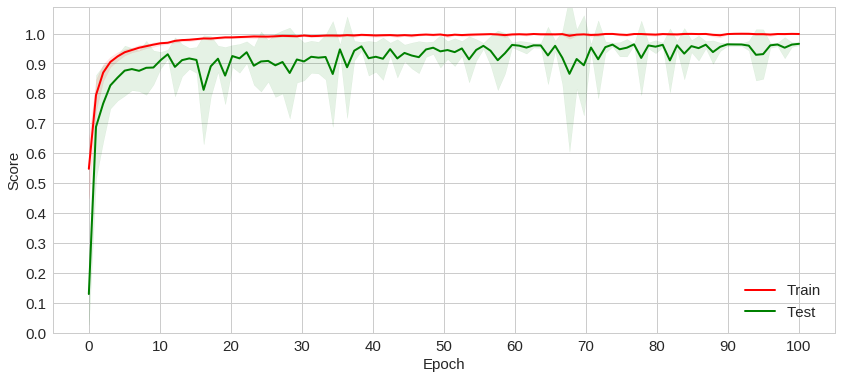

In [38]:
plot_mean_acc(hist)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

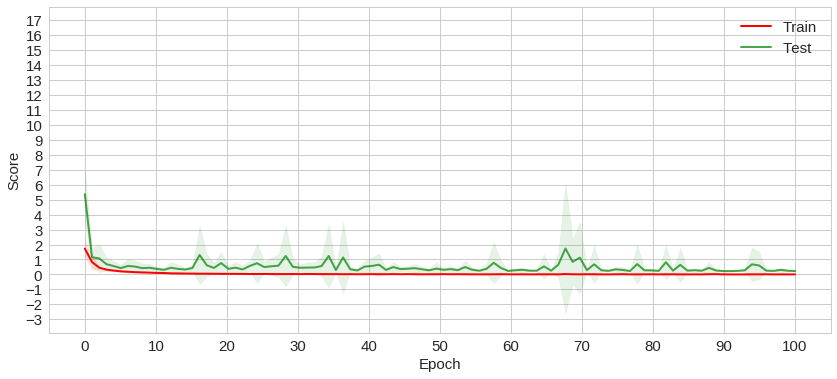

In [40]:
plot_mean_loss(hist)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

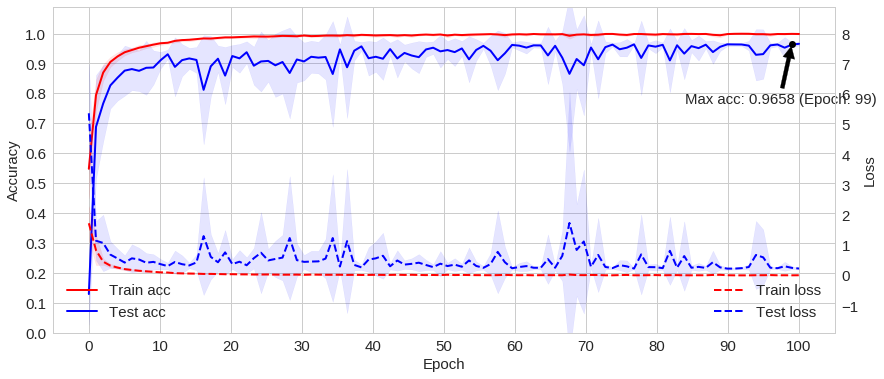

In [42]:
plot_mean(hist)